Fallstudie:<br> 
**Erstellen eines Prognosemodells des Kreditkartenzahlungsverkehr für Online-Einkäufe**

# Import & Helpers

In [4]:
#! mlflow server --host 127.0.0.1 --port 8080

In [126]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.option_context('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 100)
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

import datetime as dt
import numpy as np
import re

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style='darkgrid',)
color_pal = sns.color_palette("muted")
sns.set_palette(color_pal)
sns.set_context("paper")
%matplotlib inline
# plot dimensions
plot_width = 12
plot_height = 8
palette_success ={0: color_pal[1], 1: color_pal[2]}

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, precision_score, f1_score, recall_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

import mlflow
from mlflow.models import infer_signature

In [127]:
# parameter
rs = 23 # random state

# MLflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# date of today as string
dt_today = str(dt.date.today())

## Track model in MFflow

In [153]:
def track_model(training_info, model, x_test, y_test, y_pred, y_pred_auc, feature_names):
    """
    Logging all relevant information (metrics, parameters and feature importances) of a trained model to MLflow.
    Model-specific feature importances is used (if existing) and Permutation Feature Importance.
    """
    # Set a tag as detailed description of run
    mlflow.set_tag("Training Info", training_info)
    
    # Log the hyperparameters
    mlflow.log_params(model.get_params())
    
    # Log the metrics
    mlflow.log_metrics({"AUC": roc_auc_score(y_test, y_pred_auc), 
                       "Precision": precision_score(y_test, y_pred, zero_division=np.nan), 
                       "Recall": recall_score(y_test, y_pred, zero_division=np.nan), 
                       "F1-score": f1_score(y_test, y_pred, zero_division=np.nan)})
     
    # check options to find out model-specific FEATURE IMPORTANCES
    plot_title = "No information on feature importances"
    if (hasattr(model, "feature_importances_") == True):
        feat_imp = model.feature_importances_
        plot_title = "Feature importances"
    elif (hasattr(model, "coef_") == True):
        feat_imp = model.coef_[0]
        plot_title = "Coefficients"
    else:
        feat_imp = len(feature_names) * [0]
        print("Has NO feature importances")
    
    # save feature importance to DF
    df_feat_imp = (pd.DataFrame(list(zip(feature_names, feat_imp)), 
                             columns=["Feature", "Model_specific_imp"])
                .set_index("Feature"))
    
    # PERMUTATION FEATURE IMPORTANCE (PFI) 
    pfi_result = permutation_importance(estimator=model, X=x_test, y=y_test, scoring="roc_auc", random_state=rs, n_repeats=10)
    df_pfi = (pd.DataFrame(list(zip(feature_names, pfi_result.importances_mean)), 
                           columns=["Feature", "PFI"])
              .set_index("Feature"))
    # join both dataframes
    df_feat_imp = df_feat_imp.join(df_pfi, how="left").sort_values("PFI", ascending=False).reset_index()
    
    csv_path = "artifacts/feature_importance.csv"
    df_feat_imp.to_csv(csv_path, index=True)
    mlflow.log_artifact(csv_path, "feature_importance.csv")
    
    # Log plot of feature importance
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    sns.barplot(y="Feature", x="Model_specific_imp", data=df_feat_imp, ax=ax[0])
    ax[0].set_title("Model-specific feature importances", fontsize=10)
    sns.barplot(y="Feature", x="PFI", data=df_feat_imp, ax=ax[1])
    ax[1].set_title("Permutation feature importances", fontsize=10)
    #plt.title(plot_title)
    #plt.xlabel("Importance")
    #plt.ylabel("Feature")
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1, wspace=0.6)
    mlflow.log_figure(fig, "feature_importance.png")
    
    
    # Infer the model signature
    signature = infer_signature(x_train, y_train)
    
    # Log the model
    model_info = mlflow.sklearn.log_model(sk_model=model, 
                                          artifact_path="model_saved", 
                                          signature=signature, 
                                          input_example=x_train.head(5))

## Training of model

In [129]:
def train_model(zip_iter, x_train_raw, x_train_numerical, x_test_raw, x_test_numerical, y_train, y_test, features_numerical, exp_name, info_text):
    """
    Iterates over a list of classifiers and parameters to train models. The trained models are tracked in MLflow.
    """
    for n, c, fm in zip_iter:
        print(f"Training and logging of model {n} as classifier {c} with feature mode {fm}")
        if fm == "raw":
            x_train = x_train_raw
            x_test = x_test_raw
            feature_names = list(x_train_raw.columns)
        else:
            x_train = x_train_numerical
            x_test = x_test_numerical
            feature_names = features_numerical
            
        # Create a new MLflow Experiment
        mlflow.set_experiment(exp_name)
        
        # Start an MLflow run
        run_name = n + "_" + exp_name
        with mlflow.start_run(run_name=run_name) as run:
            training_info = n + " - " + info_text
            # Training and prediction
            model = c
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
    
            if (hasattr(model, "decision_function") == True):
                y_pred_auc = model.decision_function(x_test)
            else:
                y_pred_auc = model.predict_proba(x_test)[:, 1]
    
            track_model(training_info, model, x_test, y_test, y_pred, y_pred_auc, feature_names)
    
            run_id = run.info.run_id
        
        print(f"For {n}: Run logged in MLflow with {run_id}.")
        print("---------------------- \n")

## Hypertune models

In [130]:
def hp_tune_model(search_mode, zip_iter, 
                  x_train_raw, x_train_numerical, 
                  x_test_raw, x_test_numerical, 
                  y_train, y_test, 
                  features_numerical, exp_name, info_text):
    """
    Iterates over a list of classifiers and parameters to train models. The trained models are tracked in MLflow.
    Choose between RandomSearchCV and GridSearchCV.
    search_mode = random/grid
    """
    
    # Config RandomizedSearchCV
    scorer_auc = make_scorer(roc_auc_score, response_method=["predict_proba", "decision_function"])
    scorer_precision = make_scorer(precision_score)
    scorer_recall = make_scorer(recall_score)
    scorer_f1 = make_scorer(f1_score)
    
    cv_scoring = {"auc": scorer_auc, 
                          "precision": scorer_precision, 
                          "recall": scorer_recall, 
                          "F1": scorer_f1}
    randomized_iter = 30
    cv_folds = 5
    rs = 23
    
    for n, c, p, fm in zip_iter:
        print(f"Training and logging of model {n} as classifier {c} with feature mode {fm}")
        if fm == "raw":
            x_train = x_train_raw
            x_test = x_test_raw
            feature_names = list(x_train_raw.columns)
        else:
            x_train = x_train_numerical
            x_test = x_test_numerical
            feature_names = features_numerical

        # Create a new MLflow Experiment
        mlflow.set_experiment(exp_name)
    
        # Start an MLflow run
        run_name = n + "_BEST_" + exp_name
        with mlflow.start_run(run_name=run_name) as run:
            training_info = n + " - " + info_text

            # RandomizedSearchCV or GridSearchCV
            if (search_mode == "random"):
                random_search = RandomizedSearchCV(c, 
                                                   param_distributions=p, 
                                                   n_iter=randomized_iter, 
                                                   verbose=2, 
                                                   cv=cv_folds, 
                                                   scoring=cv_scoring, 
                                                   refit="auc", 
                                                   random_state=rs, 
                                                   error_score="raise")
                # Training and prediction
                random_search.fit(x_train, y_train)
                model_best = random_search.best_estimator_
            else:
                grid_search = GridSearchCV(c, 
                                           param_grid=p, 
                                           scoring=cv_scoring, 
                                           refit="auc", 
                                           cv=cv_folds, 
                                           verbose=2, 
                                           error_score="raise")
                # Training and prediction
                grid_search.fit(x_train, y_train)
                model_best = grid_search.best_estimator_
                
            y_pred = model_best.predict(x_test)

            if (hasattr(model_best, "decision_function") == True):
                y_pred_auc = model_best.decision_function(x_test)
            else:
                y_pred_auc = model_best.predict_proba(x_test)[:, 1]
    
            track_model(training_info, model_best, x_test, y_test, y_pred, y_pred_auc, feature_names)
    
            run_id = run.info.run_id
        
        print(f"For {n}: Run logged in MLflow with {run_id}.")
        print("---------------------- \n")

# Data preparation 2

In [131]:
# for TRAINING: load first attempt per customer transaction per PSP
df_trx = (pd.read_excel("../data/03_interim/df_trx_training.xlsx", sheet_name="df_trx")
          .drop(columns=["Unnamed: 0"])
          .rename(columns={"x_tmsp":"meta_tmsp"}))

In [132]:
# raw x- and y-variables
x_ = [x for x in list(df_trx.columns) if re.match("^x_", x)!=None]
y_ = [y for y in list(df_trx.columns) if re.match("^y_", y)!=None]
meta_ = [m for m in list(df_trx.columns) if m.find("meta_")!=-1]

In [133]:
df_trx[x_].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37782 entries, 0 to 37781
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   x_country                  37782 non-null  object 
 1   x_amount                   37782 non-null  int64  
 2   x_psp                      37782 non-null  object 
 3   x_3d_secured               37782 non-null  int64  
 4   x_card                     37782 non-null  object 
 5   x_tmsp_wd_str              37782 non-null  object 
 6   x_tmsp_daytime             37782 non-null  object 
 7   x_tmsp_h_sin               37782 non-null  float64
 8   x_tmsp_h_cos               37782 non-null  float64
 9   x_tmsp_wd_sin              37782 non-null  float64
 10  x_tmsp_wd_cos              37782 non-null  float64
 11  x_enc_country_Austria      37782 non-null  bool   
 12  x_enc_country_Germany      37782 non-null  bool   
 13  x_enc_country_Switzerland  37782 non-null  boo

In [134]:
df_trx[meta_].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37782 entries, 0 to 37781
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   meta_tmsp              37782 non-null  datetime64[ns]
 1   meta_customer_trx_id   37782 non-null  int64         
 2   meta_customer_atpt_no  37782 non-null  int64         
 3   meta_psp_trx_id        37782 non-null  int64         
 4   meta_psp_atpt_no       37782 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 1.4 MB


Je nach Modell gibt es 2 Features-Sets:<br>

Für Modelle, die numerische Features benötigen: 
- 16 Features
- davon 6 numerische Features, die skaliert werden müssen
- und 10 Features vom Typ Boolean, die aus dem One Hot Encoding entstanden sind und als Integer encoded werden<br>

Für Modelle, bei denen der Typ der Features egal ist:
- 7 Features
- davon 2 numerische Features vom Typ Integer
- und 5 categorial Features vom Typ Object

In [135]:
# categorize features
feat_object_native = list(df_trx[x_].select_dtypes(include="object").columns) # original features of type object
#feat_object_bool_enc = list(df_trx[x_].select_dtypes(include="bool").columns) # encoded object features as bool
feat_num = list(df_trx[x_].select_dtypes(include="int").columns) # numerical features for scaling

## Train-Test-Split
Indirekter Train-Test-Split auf Basis der Customer-Transaction-ID meta_customer_trx_id.<br>
Damit wird sichergestellt, dass alle Attempts zu einem Kundenvorgang entweder nur im Trainings- oder nur im Test-Datensatz sind. Damit stehen dann später Versuche mit mehreren PSPs für einen Kundenvorgang zur Evaluierung zur Verfügung.

In [136]:
# TRAIN-TEST-SPLIT: shuffle and split by customer_trx_id
trx_id_train, trx_id_test  = train_test_split(df_trx["meta_customer_trx_id"].unique(), test_size=0.2, random_state=rs, shuffle=True)

# create x- and y-sets
x_train = df_trx[df_trx["meta_customer_trx_id"].isin(trx_id_train)].loc[:, x_]
x_test = df_trx[df_trx["meta_customer_trx_id"].isin(trx_id_test)].loc[:, x_]
y_train = df_trx[df_trx["meta_customer_trx_id"].isin(trx_id_train)].loc[:, y_]
y_test = df_trx[df_trx["meta_customer_trx_id"].isin(trx_id_test)].loc[:, y_]
# to array/series
y_train= y_train.iloc[:, 0]
y_test= y_test.iloc[:, 0]

In [137]:
len(trx_id_test)

5392

In [138]:
train_size = x_train.shape[0]
test_size = x_test.shape[0]
print(f"Trainings data set consists of {train_size} records, while the test data set consists of {test_size} records.")

Trainings data set consists of 30270 records, while the test data set consists of 7512 records.


## Feature Engineering Pipeline

In [139]:
# column transformer for models requiring numerical, scaled input features
coltransformer_4numerical = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include="number")), 
    (OrdinalEncoder(), make_column_selector(dtype_include="bool"))
)

## Features

In [140]:
# for model with numerical input
coltransformer_4numerical.fit(x_train)
x_train_numerical = coltransformer_4numerical.transform(x_train)
x_test_numerical = coltransformer_4numerical.transform(x_test)

In [141]:
# names of transformed features
transformed_features = coltransformer_4numerical.get_feature_names_out()

In [142]:
# for model with raw input
x_train_raw = x_train[feat_num + feat_object_native]
x_test_raw = x_test[feat_num + feat_object_native]

# Modeling no. 1 

## Test design
Ziele:
- erfolgreiche Transaktionen in Abhängigkeit vom PSP (und den anderen Umständen) erkennen
- positiv = success
- wir müssen dem Kunden einen PSP zuordnen und wollen daher den PSP wählen, der die höchste Erfolgswahrscheinlichkeit hat
- keine PSP zu wählen ist keine Option
  
Vergleich der Modelle:
- Wir sind nicht nur an der Klassifikation an sich interessiert, sondern v.a. auch an der Wahrscheinlichkeit für einen Erfolg abhängig von dem PSP. Der Predictor muss keine fixe Vorhersage über Erfolg/Misserfolg treffen, sondern in Abhängigkeit vom PSP die Erfolgswahrscheinlichkeit berechnen (es wird kein Threshold festgelegt).
- AUC ist eine Vergleichsmetrik, die unabhängig vom gewählten Threshold ist.

Weitere Metriken zur Bewertung der Performance, aber nicht entscheidend:
- Precision meiner Vorhersage: keine Falschpositiven, um mehrfache Transaktionsgebühren zu sparen
- Recall/TPR/Sensitivity: möglichst viele erfolgreiche Transaktionen vorhersagen, um eine Auswahl an PSPs zu haben, um die Kosten minimieren zu können
- F1-Score als harmonisches Mittel

## Baseline model
2 Strategien kommen in Frage:
- most_frequent: macht wenig Sinn, weil dann kein Erfolg vorhergesagt wird, so dass Precision nicht berechnet werden kann. Recall/Sensitity ist ebenfalls = 0
- stratified: It generates predictions by respecting the class distribution of the training data. It is different from the “most frequent” strategy as it instead associates a probability with each data point of being the most frequent class label.

In [143]:
# Training and prediction
baseline_clf = DummyClassifier(strategy="stratified", random_state=rs)
baseline_clf.fit(x_train_raw, y_train)

y_pred_baseline = baseline_clf.predict(x_test_raw)
y_pred_baseline_prob = baseline_clf.predict_proba(x_test_raw)
auc = roc_auc_score(y_test, y_pred_baseline_prob[:, 1], average="macro")
prec = precision_score(y_test, y_pred_baseline, zero_division=np.nan)
recall = recall_score(y_test, y_pred_baseline, zero_division=np.nan)
f1 = f1_score(y_test, y_pred_baseline, zero_division=np.nan)

print(f"Baseline-model")
print(f"with AUC: {auc:.2f}")
print(f"with precision: {prec:.2f}")
print(f"with recall: {recall:.2f}")
print(f"and F1-score: {f1:.2f}")

Baseline-model
with AUC: 0.50
with precision: 0.21
with recall: 0.21
and F1-score: 0.21


## 1st training of models (w/o class_weights)
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression<br>
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB<br>
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier<br>
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier<br>
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC<br>
https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis<br>
https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn-ensemble-gradientboostingclassifier<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier

In [144]:
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

In [145]:
# collect all models
# names
first_step_clf_names = ["Baseline model stratified", 
                        "Logistic Regression", 
                        "Naive Bayes", 
                        "KNN", 
                        "Decision Tree", 
                        "Linear SVM",  
                        "LDA", 
                        "QDA",
                        "Random Forest", 
                        "Gradient Boosting", 
                        "Extra Trees"]

# configure random see
params_rs = {"random_state": rs}

# sklearn models
first_step_clf = [DummyClassifier(strategy="stratified", **params_rs), 
                  LogisticRegression(class_weight="balanced", penalty=None, **params_rs), 
                  CategoricalNB(), 
                  KNeighborsClassifier(), 
                  DecisionTreeClassifier(class_weight="balanced", **params_rs),
                  LinearSVC(class_weight="balanced", **params_rs),
                  LinearDiscriminantAnalysis(), 
                  QuadraticDiscriminantAnalysis(),
                  RandomForestClassifier(class_weight="balanced_subsample", **params_rs), 
                  GradientBoostingClassifier(**params_rs), 
                  ExtraTreesClassifier(class_weight="balanced_subsample", **params_rs)]

# feature mode for model
first_step_feat_mode = ["raw", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric"]

first_step_zip = zip(first_step_clf_names, first_step_clf, first_step_feat_mode)
print(f"length of clf_names {len(first_step_clf_names)} & clf {len(first_step_clf)} & feat_mode {len(first_step_feat_mode)}")

length of clf_names 11 & clf 11 & feat_mode 11


Training and logging of model Baseline model stratified as classifier DummyClassifier(random_state=23, strategy='stratified') with feature mode raw
Has NO feature importances
For Baseline model stratified: Run logged in MLflow with dd3a8591e3494a40b56d65d02e4cee1b.
---------------------- 

Training and logging of model Logistic Regression as classifier LogisticRegression(class_weight='balanced', penalty=None, random_state=23) with feature mode numeric
For Logistic Regression: Run logged in MLflow with e2a0af46e84a471ab60e4a347fe6f807.
---------------------- 

Training and logging of model Naive Bayes as classifier CategoricalNB() with feature mode numeric
Has NO feature importances
For Naive Bayes: Run logged in MLflow with 6b80dd9b063c4a478afb1a9260f34d76.
---------------------- 

Training and logging of model KNN as classifier KNeighborsClassifier() with feature mode numeric
Has NO feature importances
For KNN: Run logged in MLflow with ffe20ef672574ced8b84984516d7c2ad.
--------------

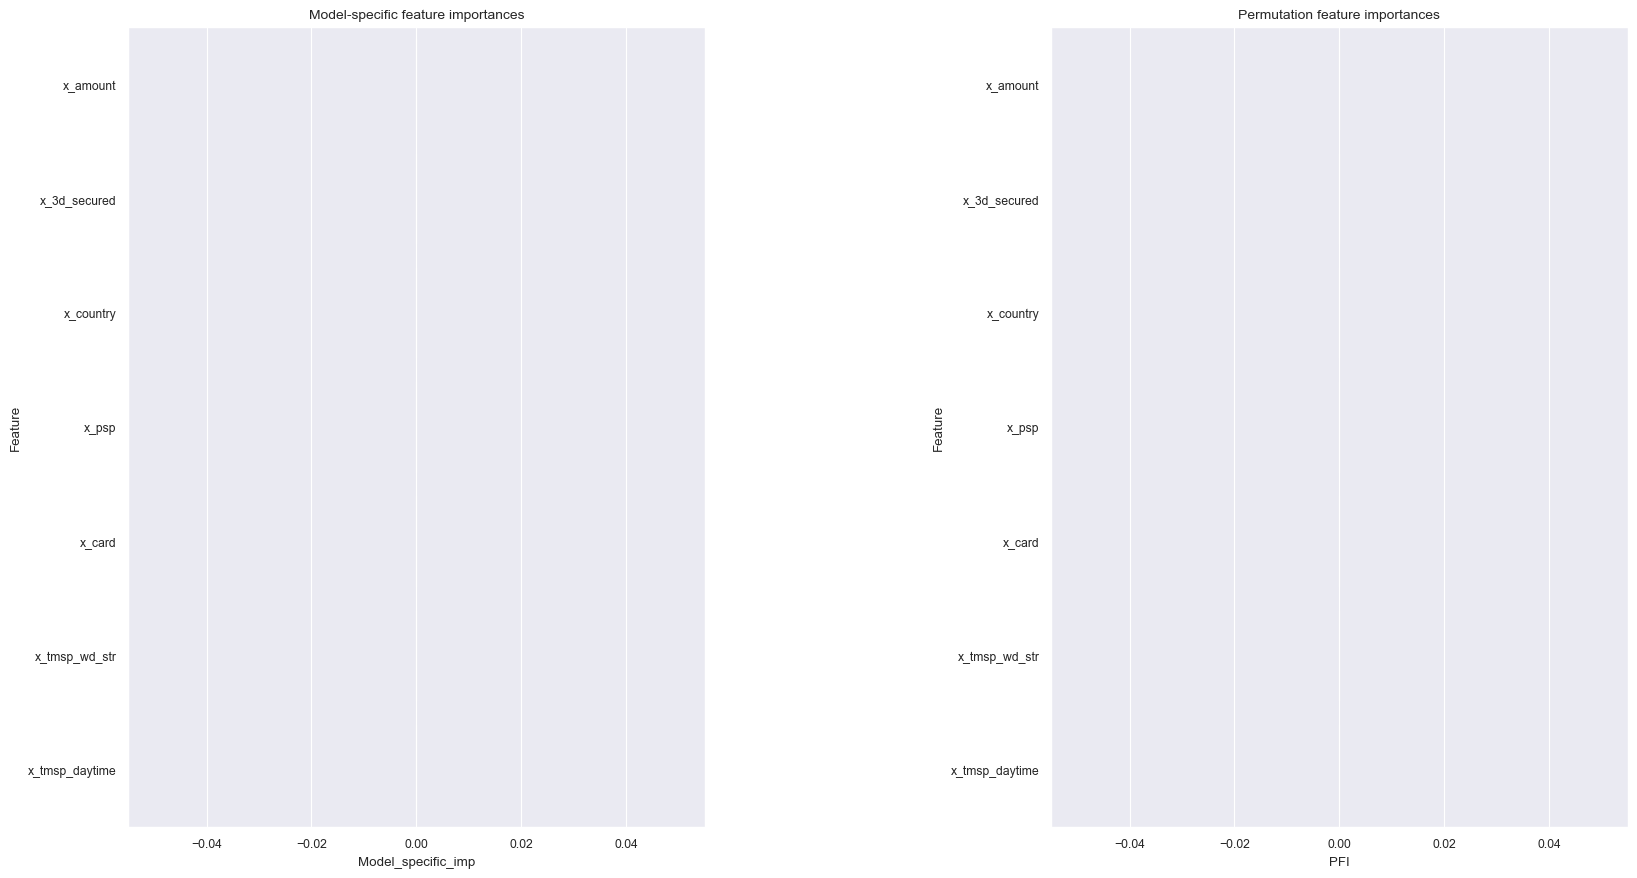

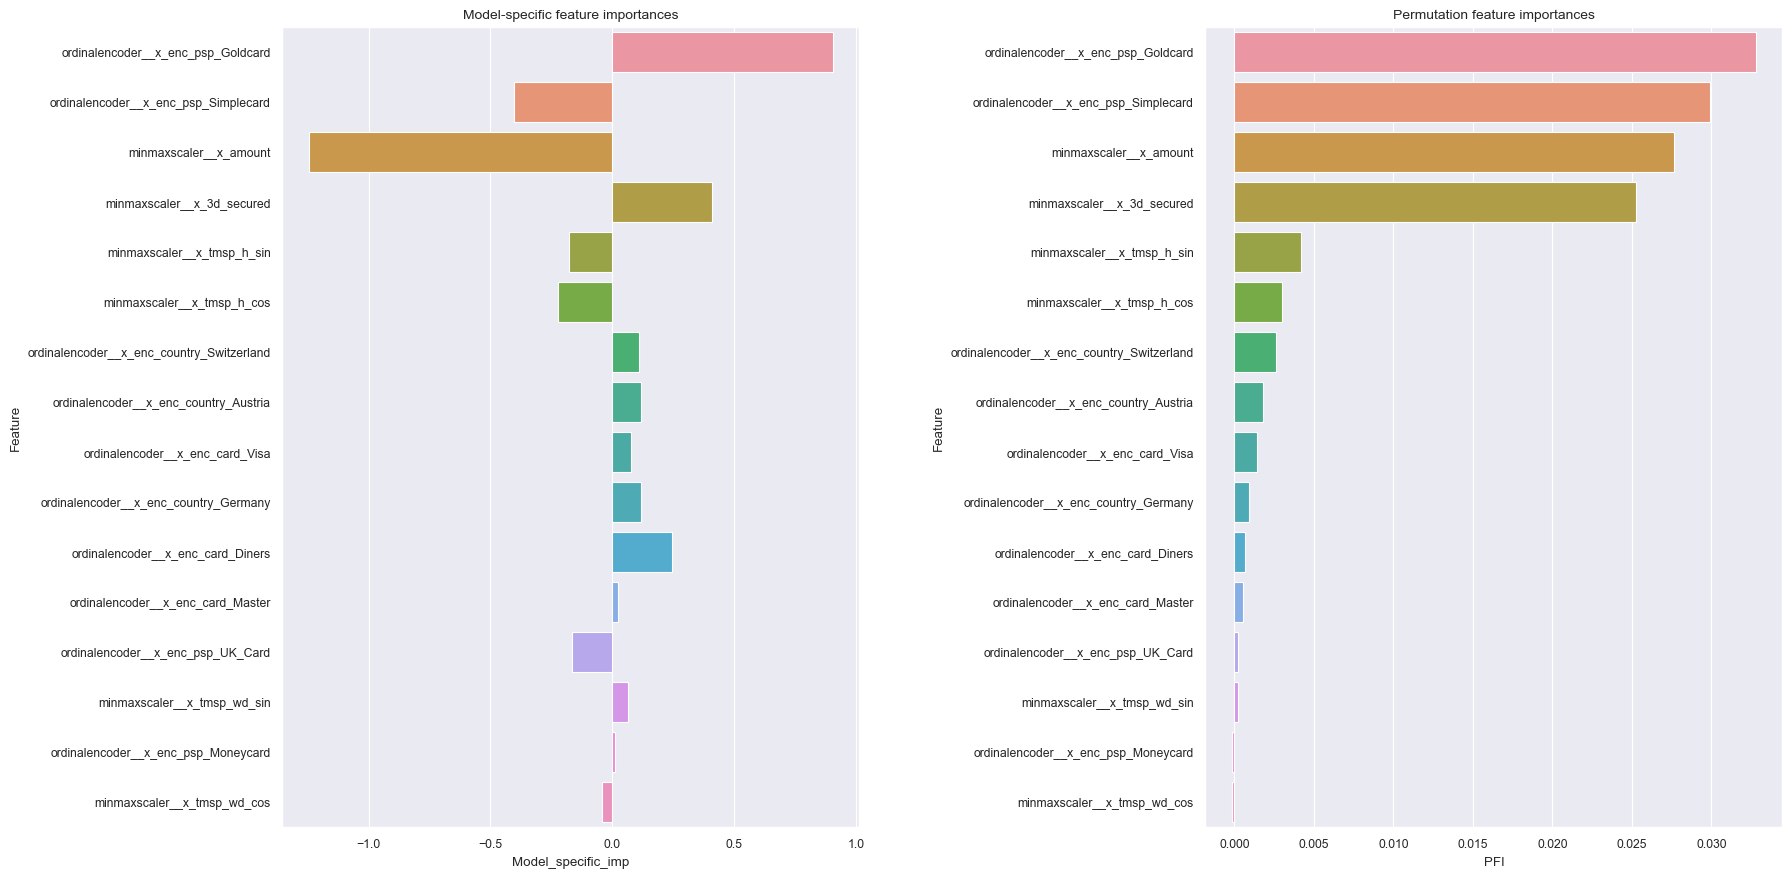

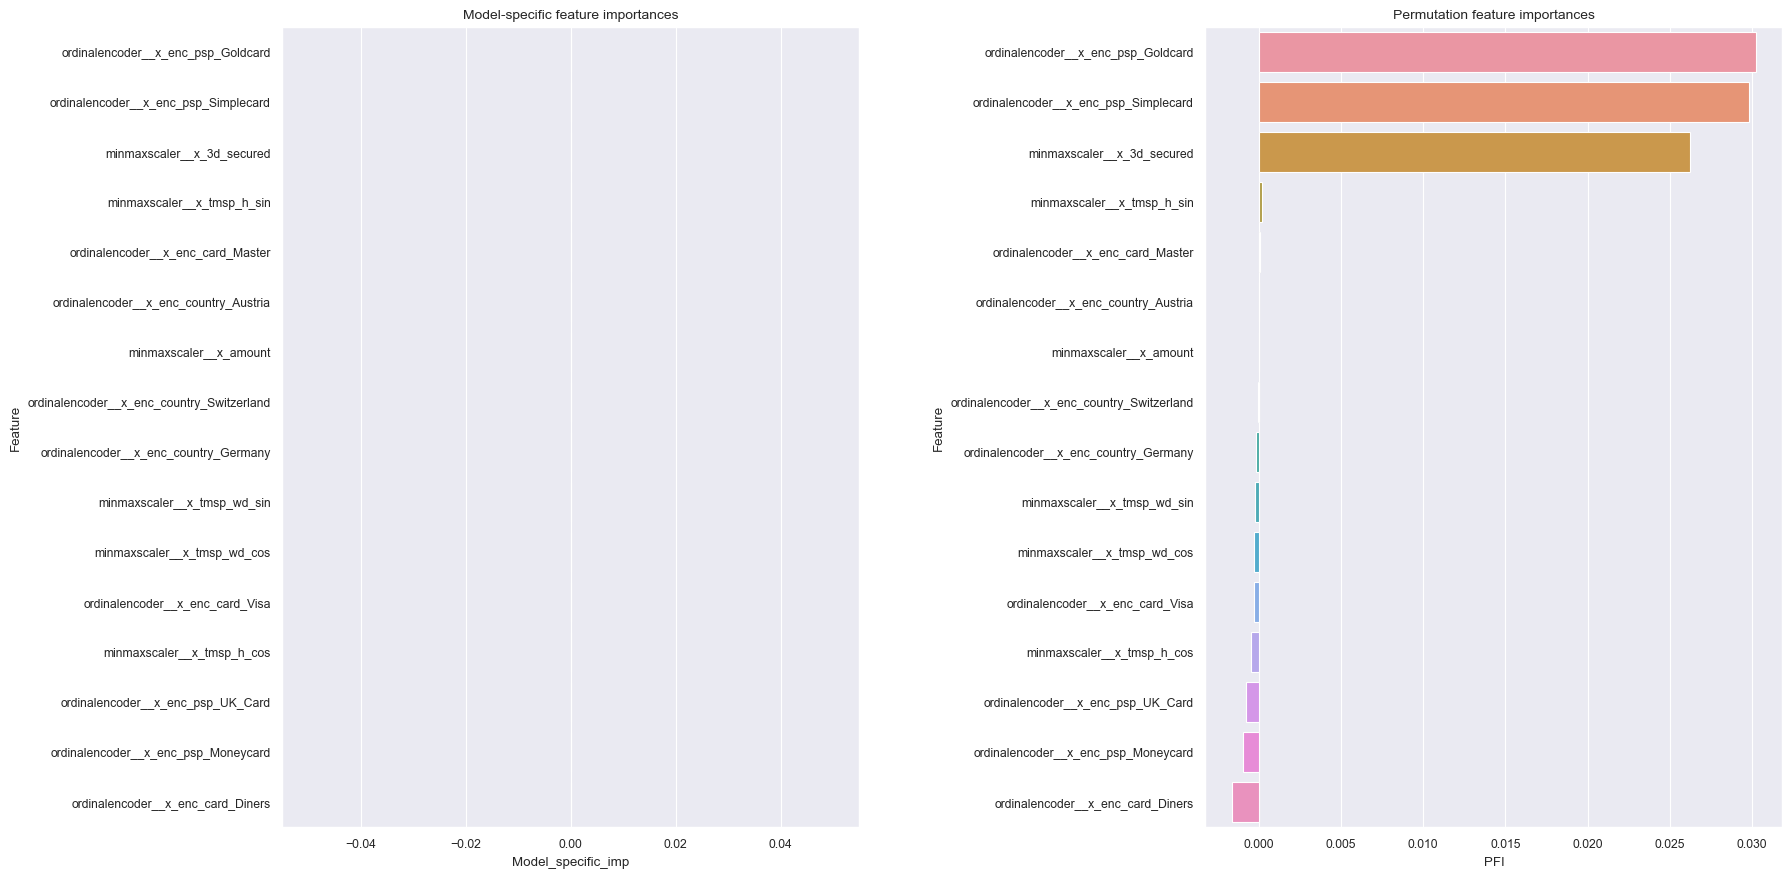

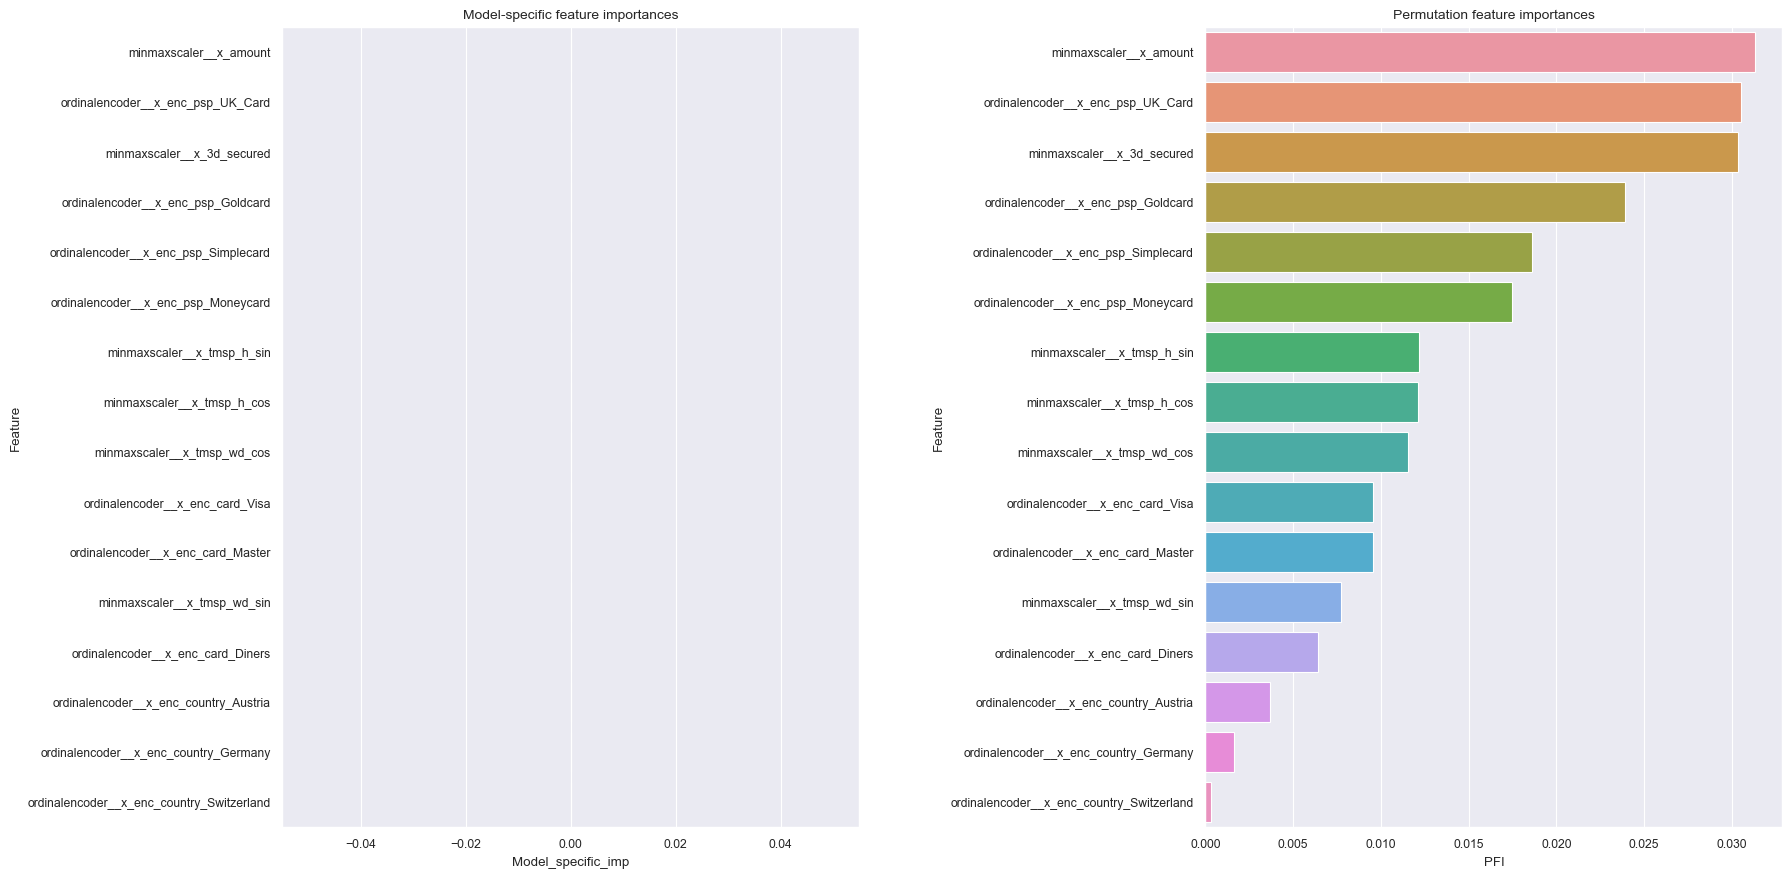

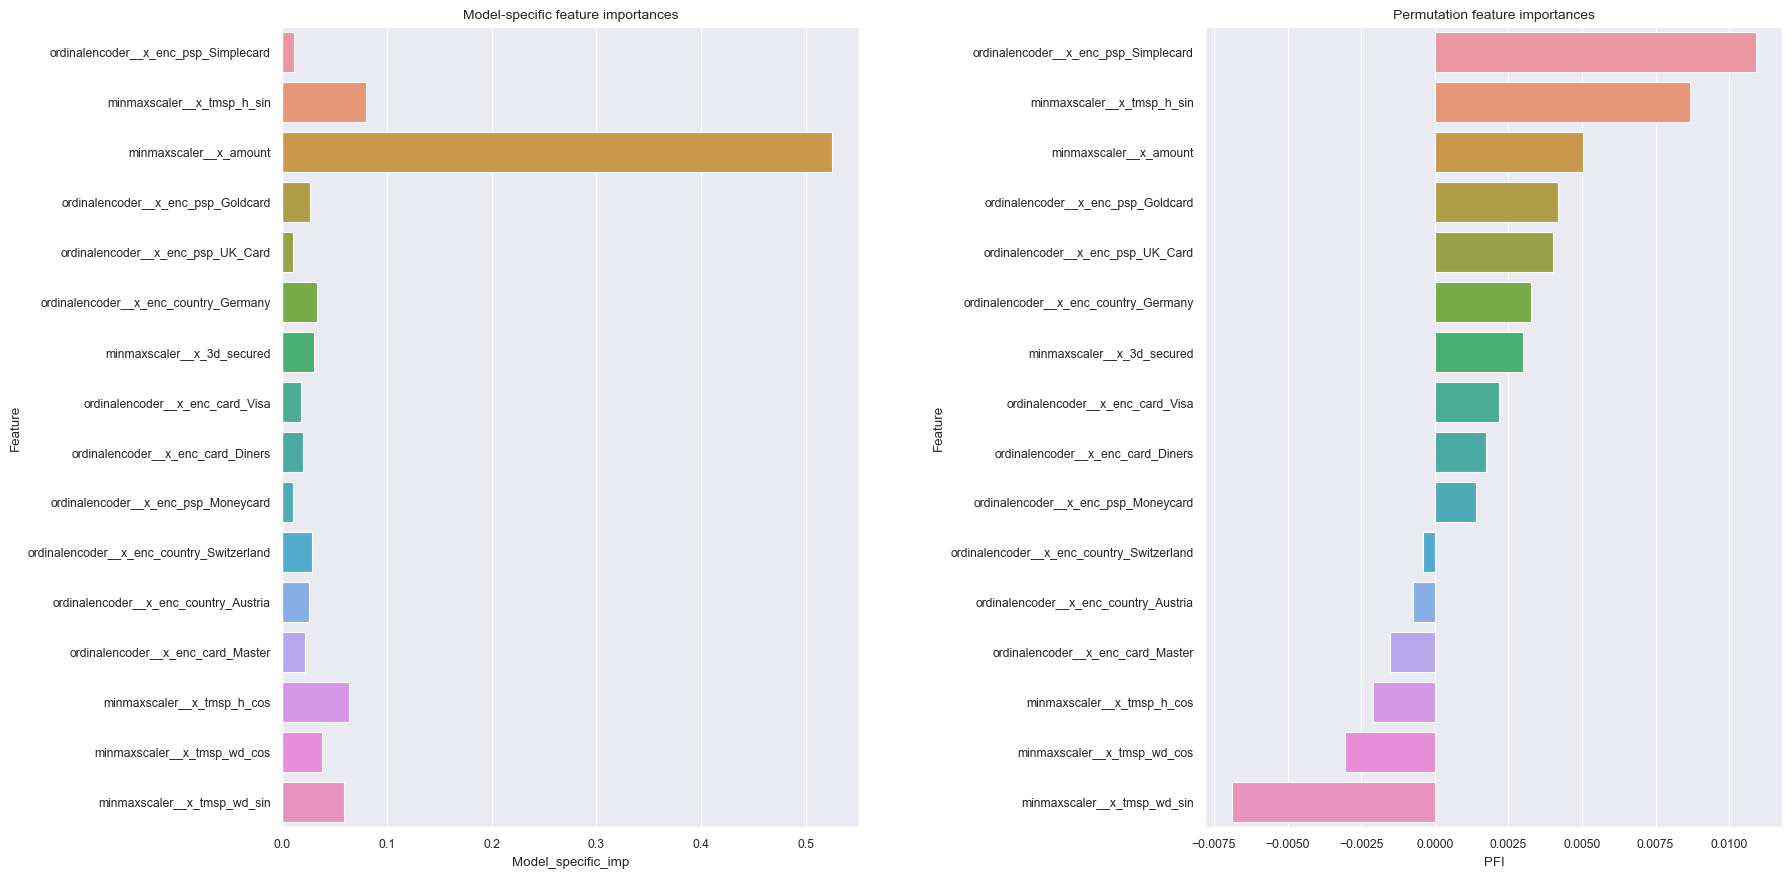

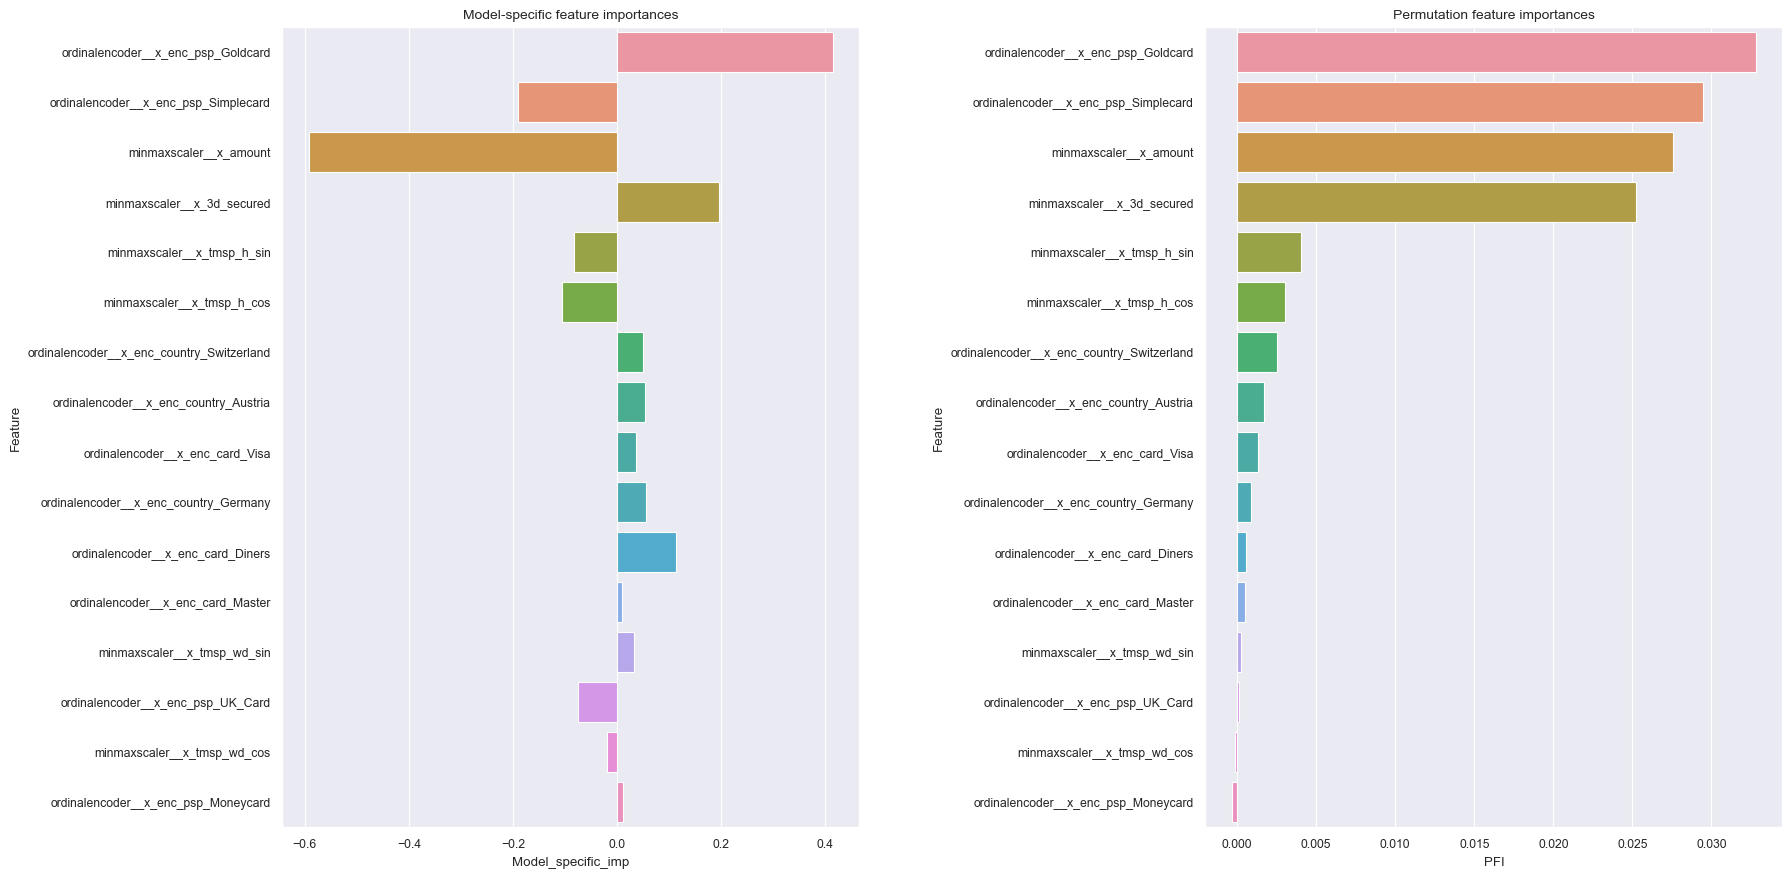

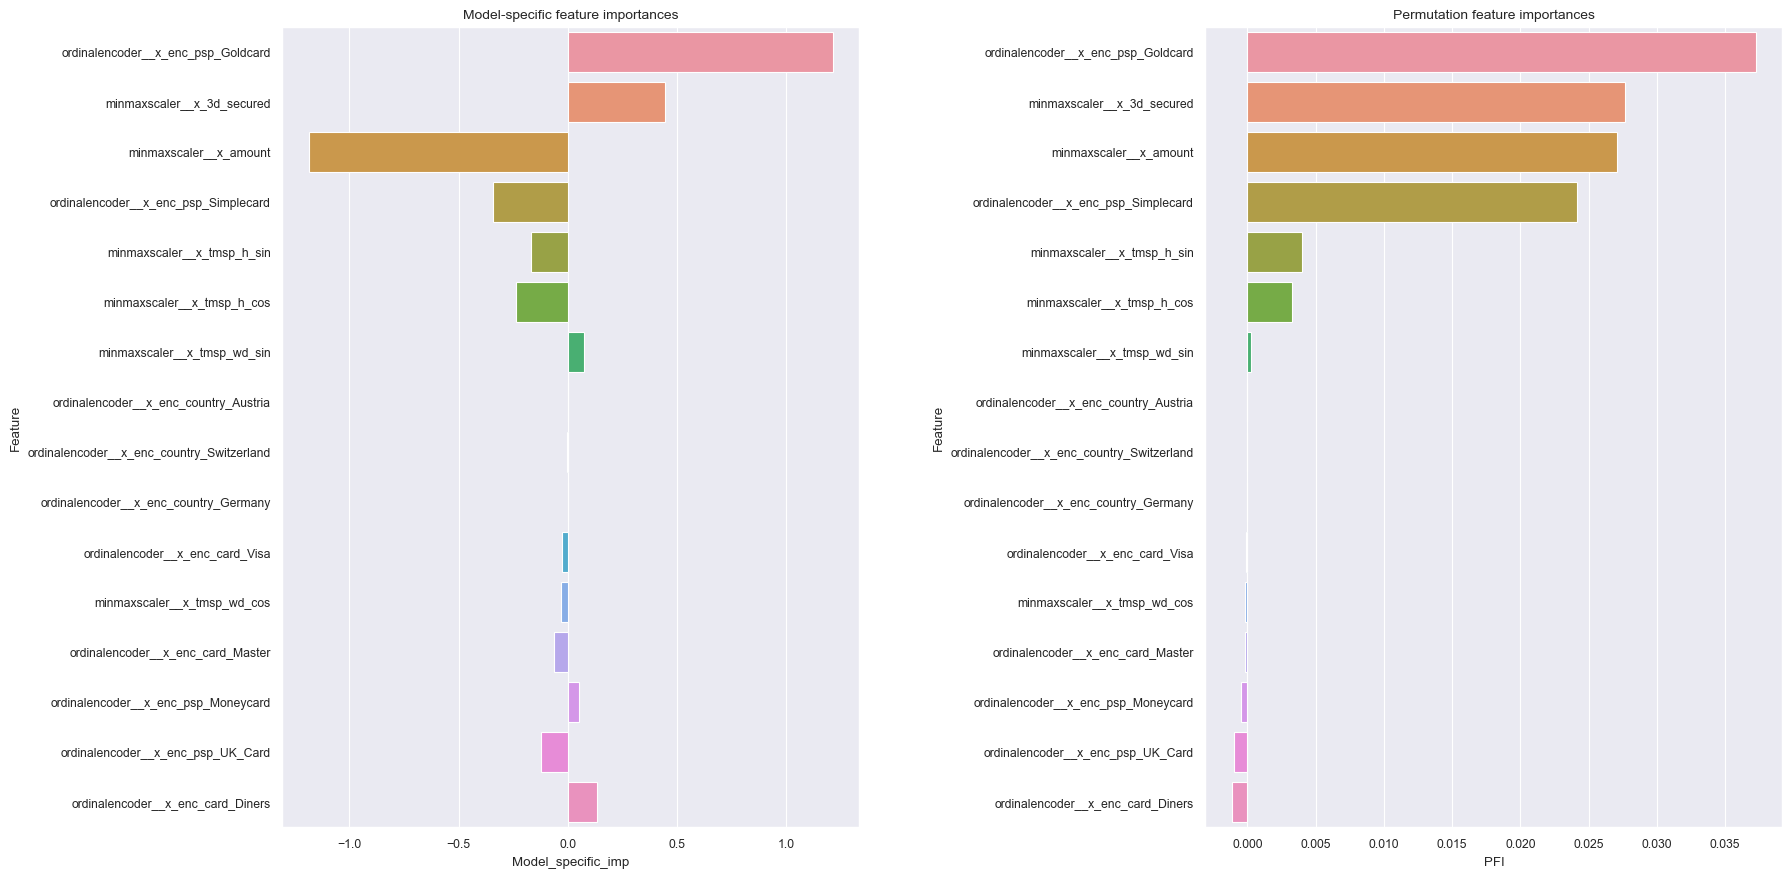

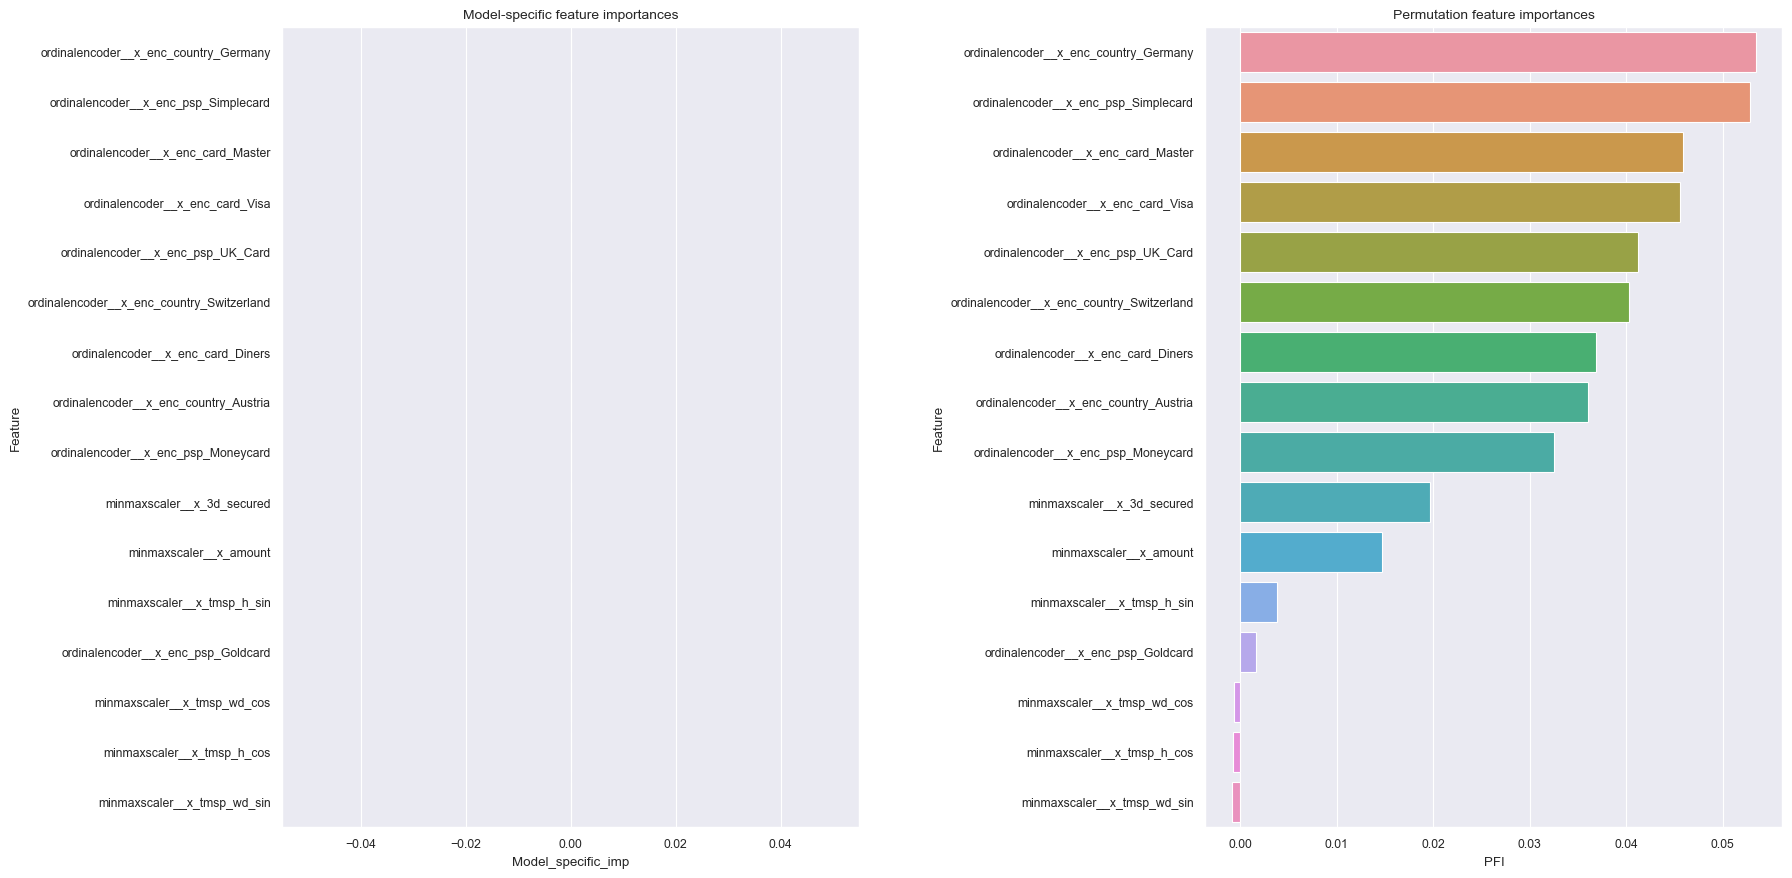

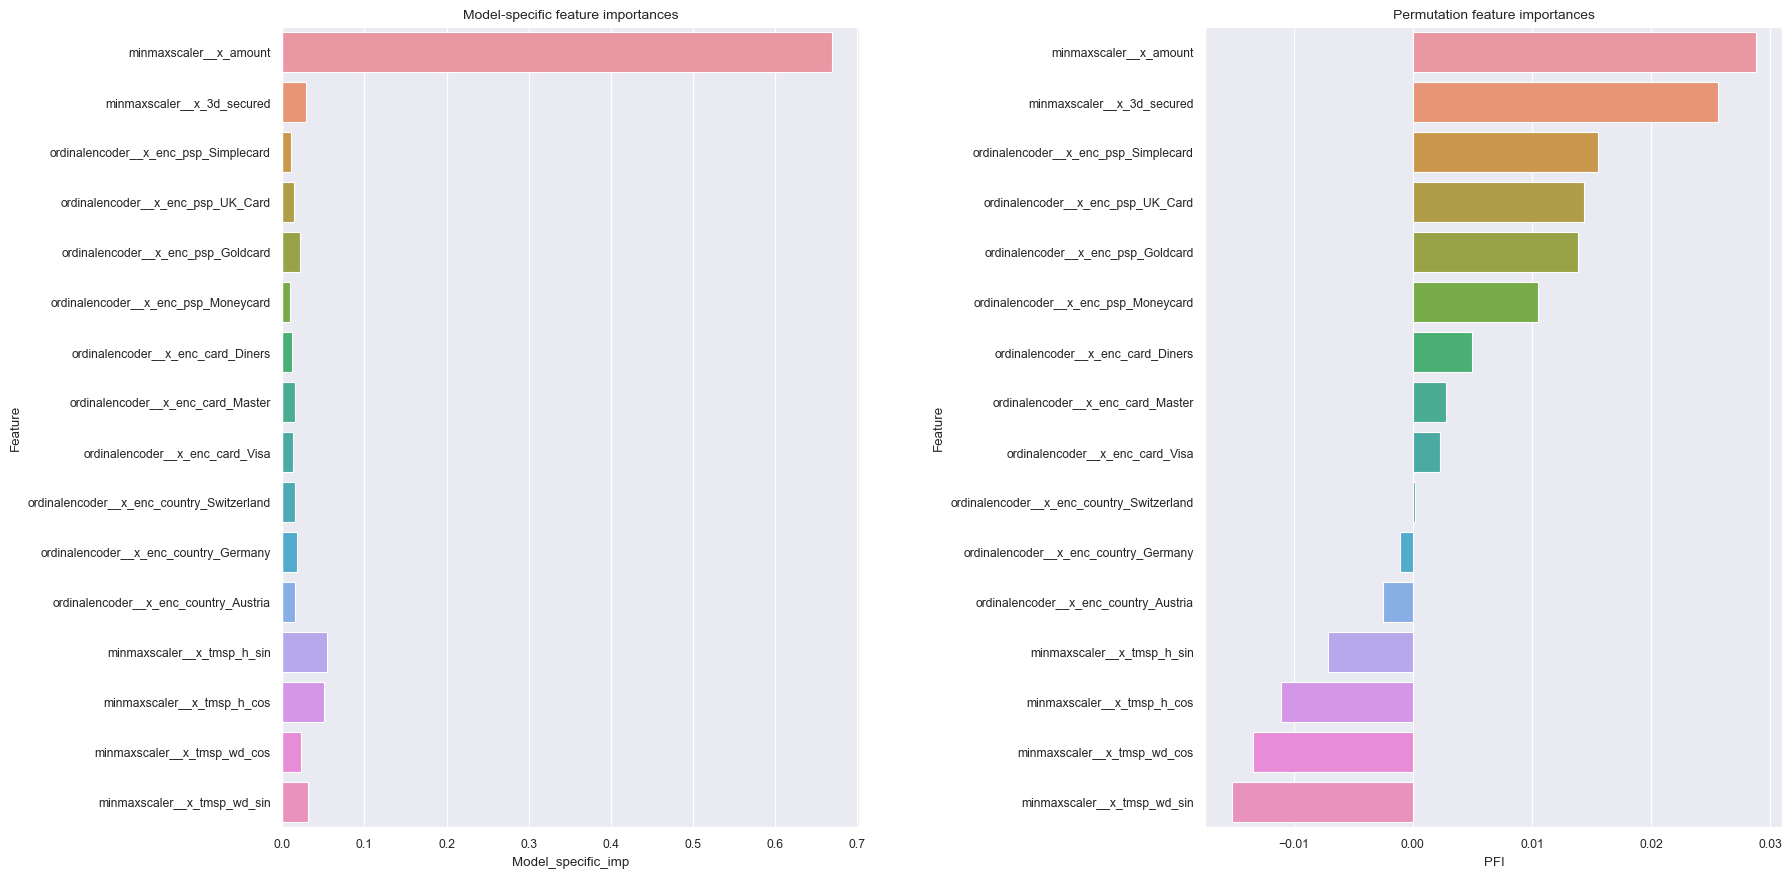

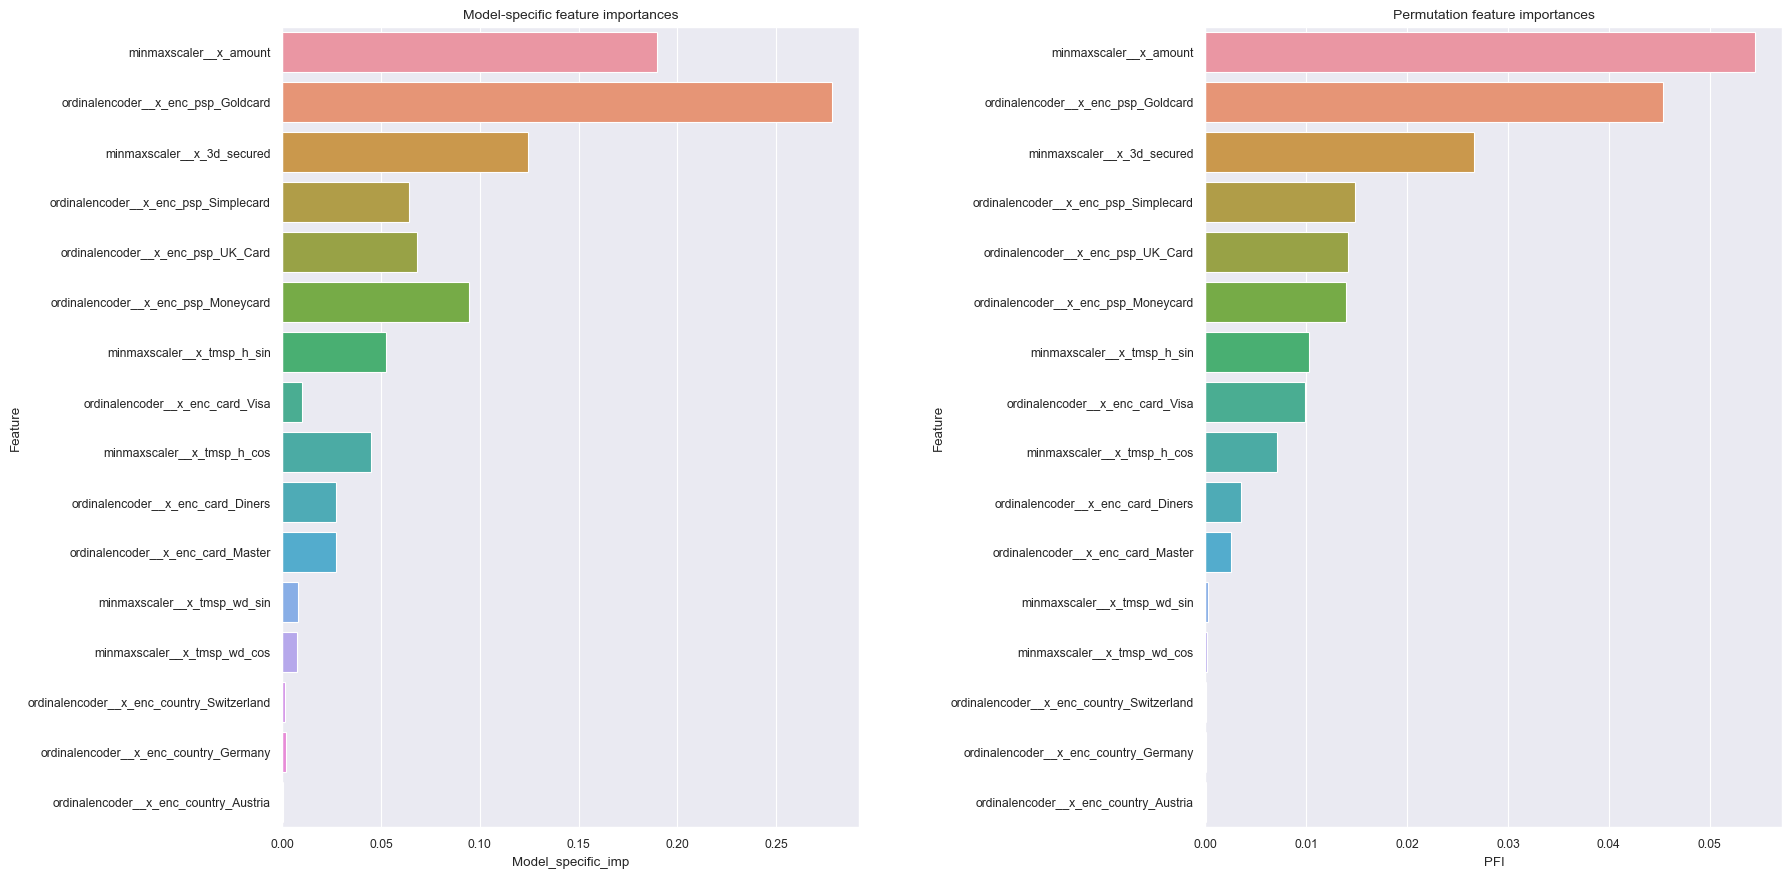

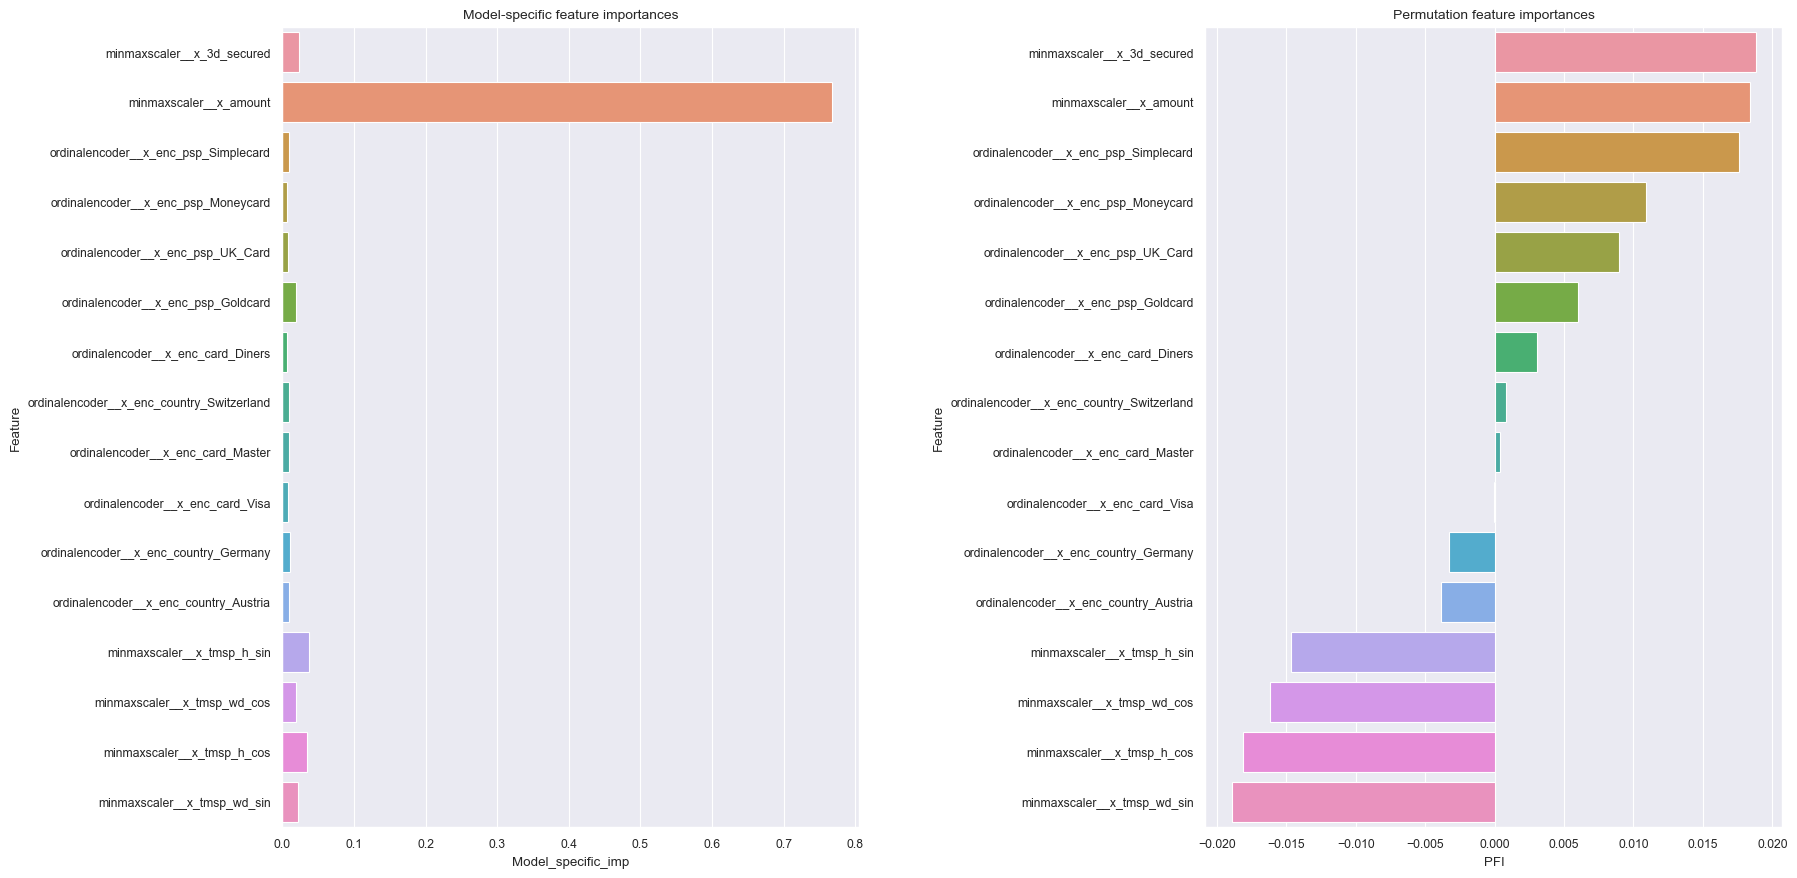

In [146]:
first_exp = "PSP_1b_w/_class_weights"
first_info = "1. Training for comparison of models WITH hyperparameter tuning"
train_model(zip_iter=first_step_zip, 
            x_train_raw=x_train_raw, x_train_numerical=x_train_numerical, 
            x_test_raw=x_test_raw, x_test_numerical=x_test_numerical, 
            y_train=y_train, y_test=y_test,
            features_numerical=transformed_features, 
            exp_name=first_exp, info_text=first_info)

## Evaluate & understand 1st model training

Features with lowest performance:
- Country: Austria, Germany, Switzerland
- Working day

# Modeling no. 2: Remove least important features and models with lowest performance

## Drop features

In [147]:
# LIGHT set for raw features
x_train_raw_light = x_train_raw.drop(columns=["x_tmsp_wd_str", "x_country"])
x_test_raw_light = x_test_raw.drop(columns=["x_tmsp_wd_str", "x_country"])

In [148]:
# columns to remove in numerical input
index_to_drop = [list(transformed_features).index(i) for i in transformed_features if (i.find("_country_")!=-1) or (i.find("_wd_")!=-1)]

# LIGHT set for model with numerical input
features_light = np.delete(transformed_features, index_to_drop, 0)
x_train_numerical_light = np.delete(x_train_numerical, index_to_drop, 1)
x_test_numerical_light = np.delete(x_test_numerical, index_to_drop, 1)

## Training of models

In [149]:
# collect all models
# names
second_step_clf_names = ["Baseline model stratified", 
                        "Logistic Regression", 
                        "Naive Bayes", 
                        "KNN", 
                        "Decision Tree", 
                        "Linear SVM",   
                        "LDA", 
                        "QDA",
                        "Random Forest", 
                        "Gradient Boosting", 
                        "Extra Trees"]

# sklearn models
second_step_clf = [DummyClassifier(strategy="stratified", **params_rs), 
                  LogisticRegression(class_weight="balanced", penalty=None, **params_rs), 
                  CategoricalNB(), 
                  KNeighborsClassifier(), 
                  DecisionTreeClassifier(class_weight="balanced", **params_rs),
                  LinearSVC(class_weight="balanced", **params_rs),
                  LinearDiscriminantAnalysis(), 
                  QuadraticDiscriminantAnalysis(),
                  RandomForestClassifier(class_weight="balanced_subsample", **params_rs), 
                  GradientBoostingClassifier(**params_rs), 
                  ExtraTreesClassifier(class_weight="balanced_subsample", **params_rs)]

# feature mode for model
second_step_feat_mode = ["raw", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric"]

second_step_zip = zip(second_step_clf_names, second_step_clf, second_step_feat_mode)
print(f"length of clf_names {len(second_step_clf_names)} & clf {len(second_step_clf)} & feat_mode {len(second_step_feat_mode)}")

length of clf_names 11 & clf 11 & feat_mode 11


Training and logging of model Baseline model stratified as classifier DummyClassifier(random_state=23, strategy='stratified') with feature mode raw
Has NO feature importances
For Baseline model stratified: Run logged in MLflow with ce39fc87c2234b5fb78c64063b6391a8.
---------------------- 

Training and logging of model Logistic Regression as classifier LogisticRegression(class_weight='balanced', penalty=None, random_state=23) with feature mode numeric
For Logistic Regression: Run logged in MLflow with fce6cdc36afd4e49bf198583841f6cda.
---------------------- 

Training and logging of model Naive Bayes as classifier CategoricalNB() with feature mode numeric
Has NO feature importances
For Naive Bayes: Run logged in MLflow with 7dab7da3dddc40db8aa0d4071c3bc63e.
---------------------- 

Training and logging of model KNN as classifier KNeighborsClassifier() with feature mode numeric
Has NO feature importances
For KNN: Run logged in MLflow with a9c43d3b83334bcfb7228ab31fd23972.
--------------

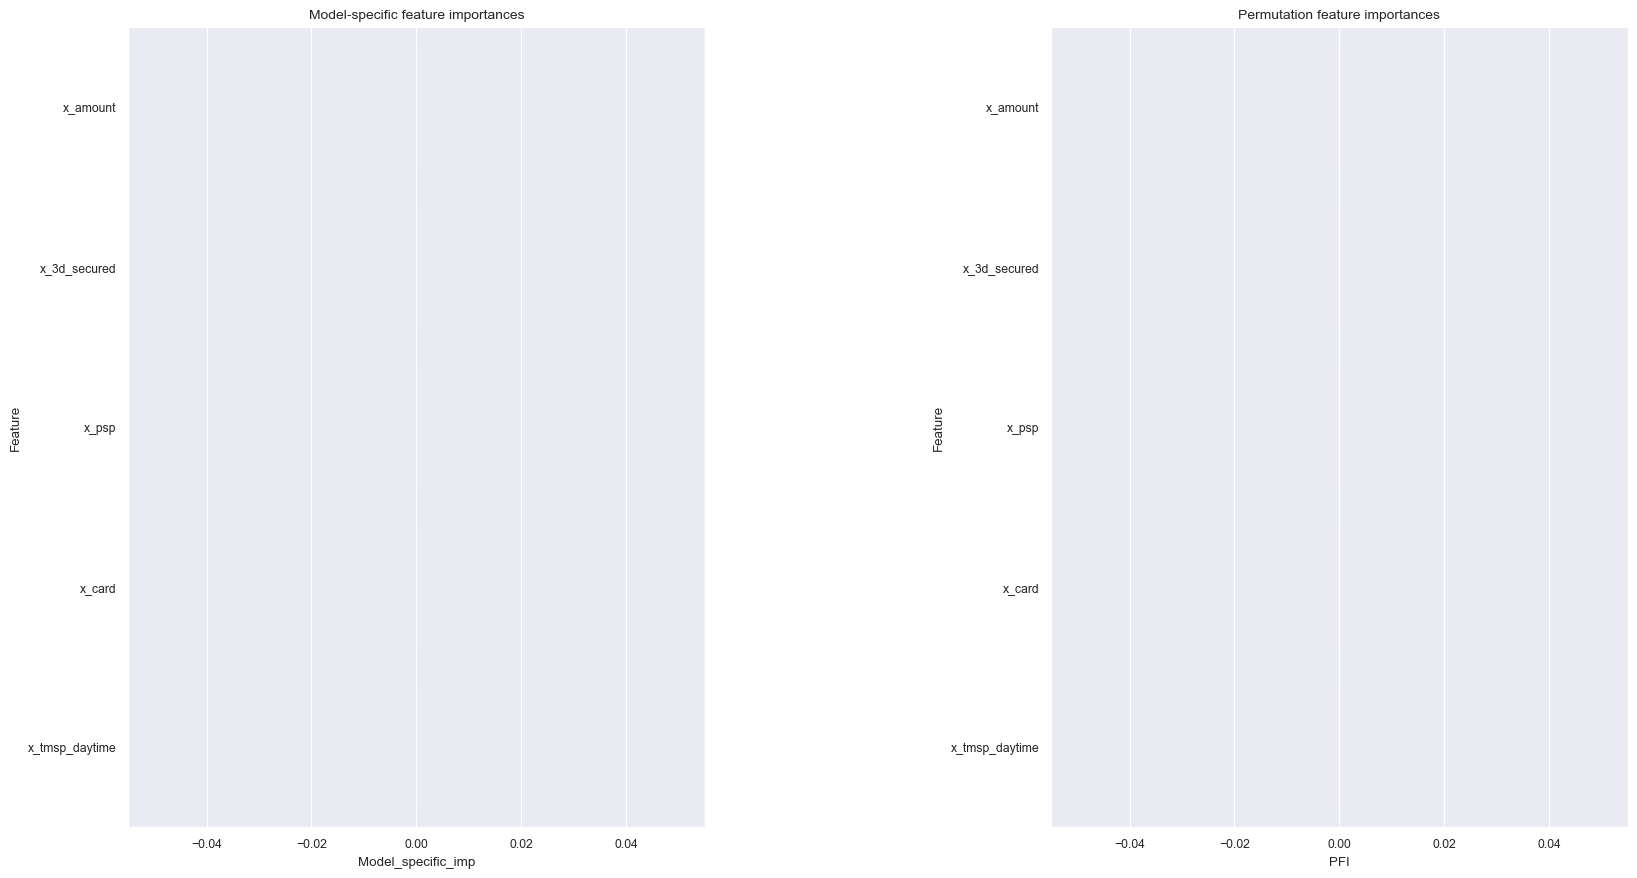

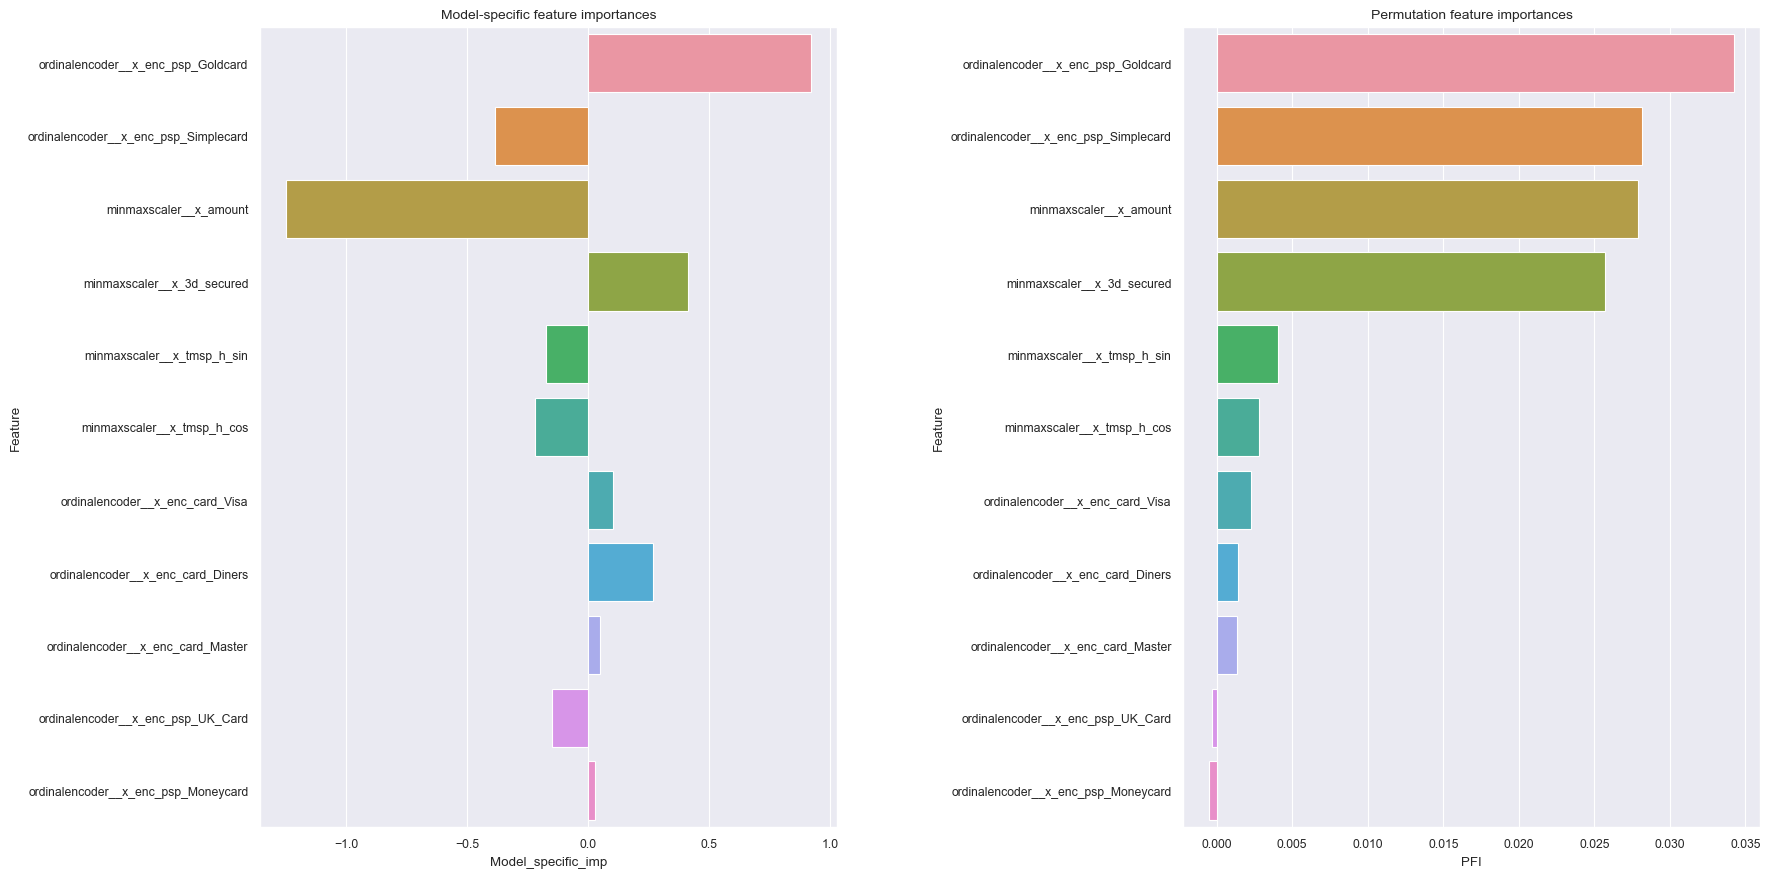

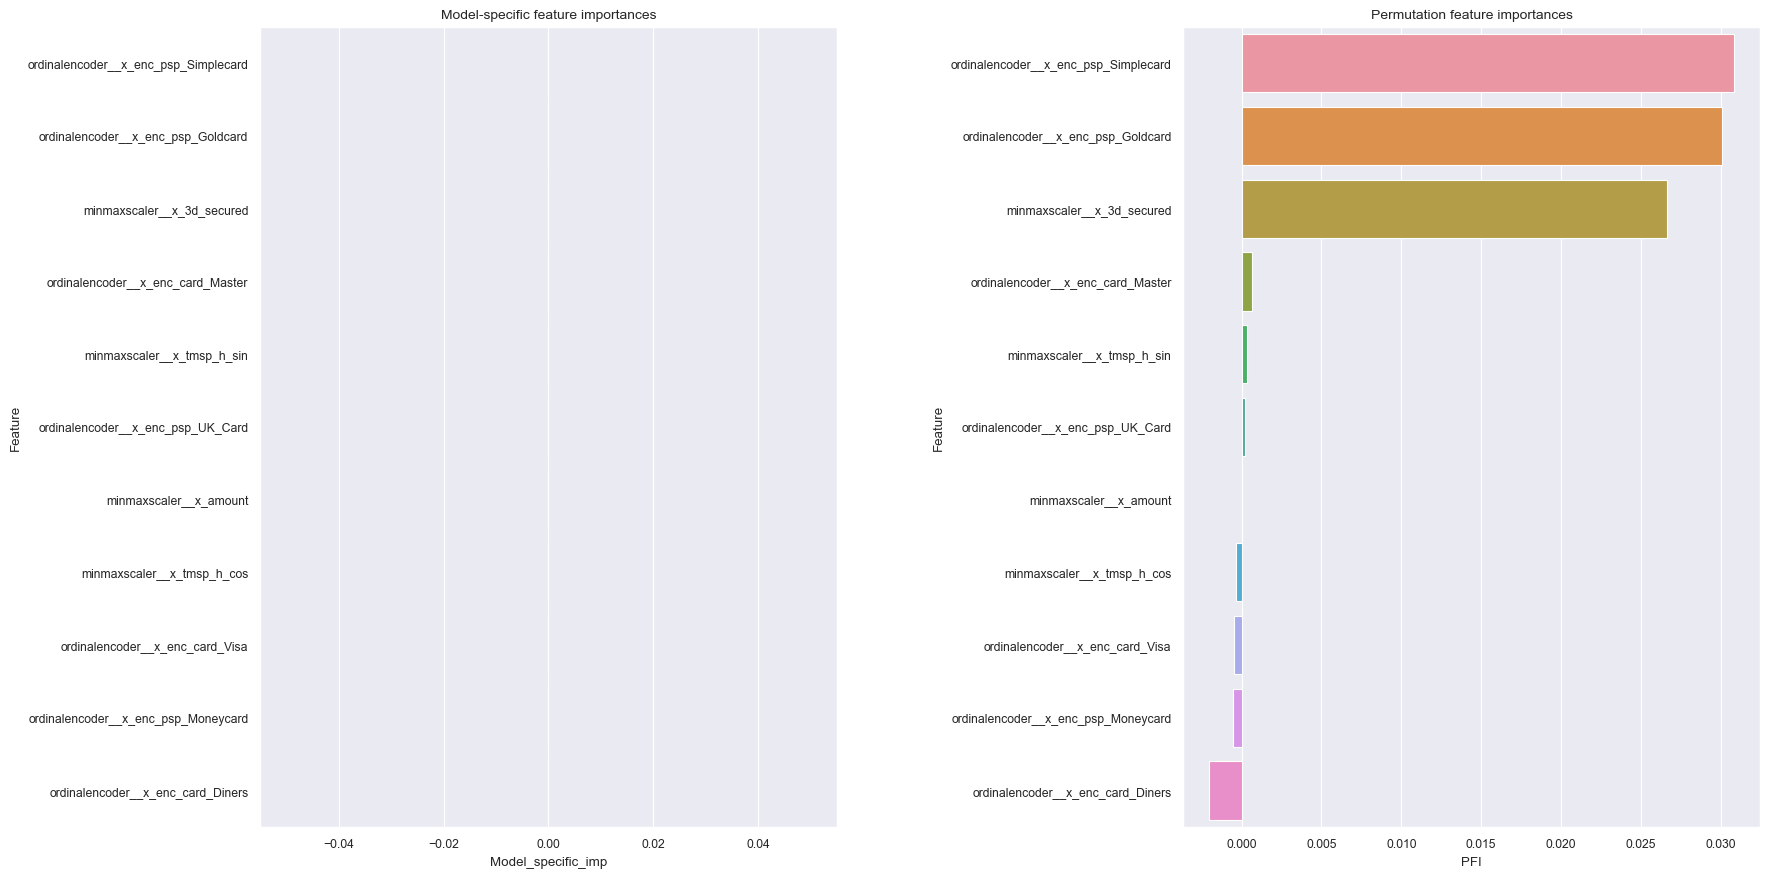

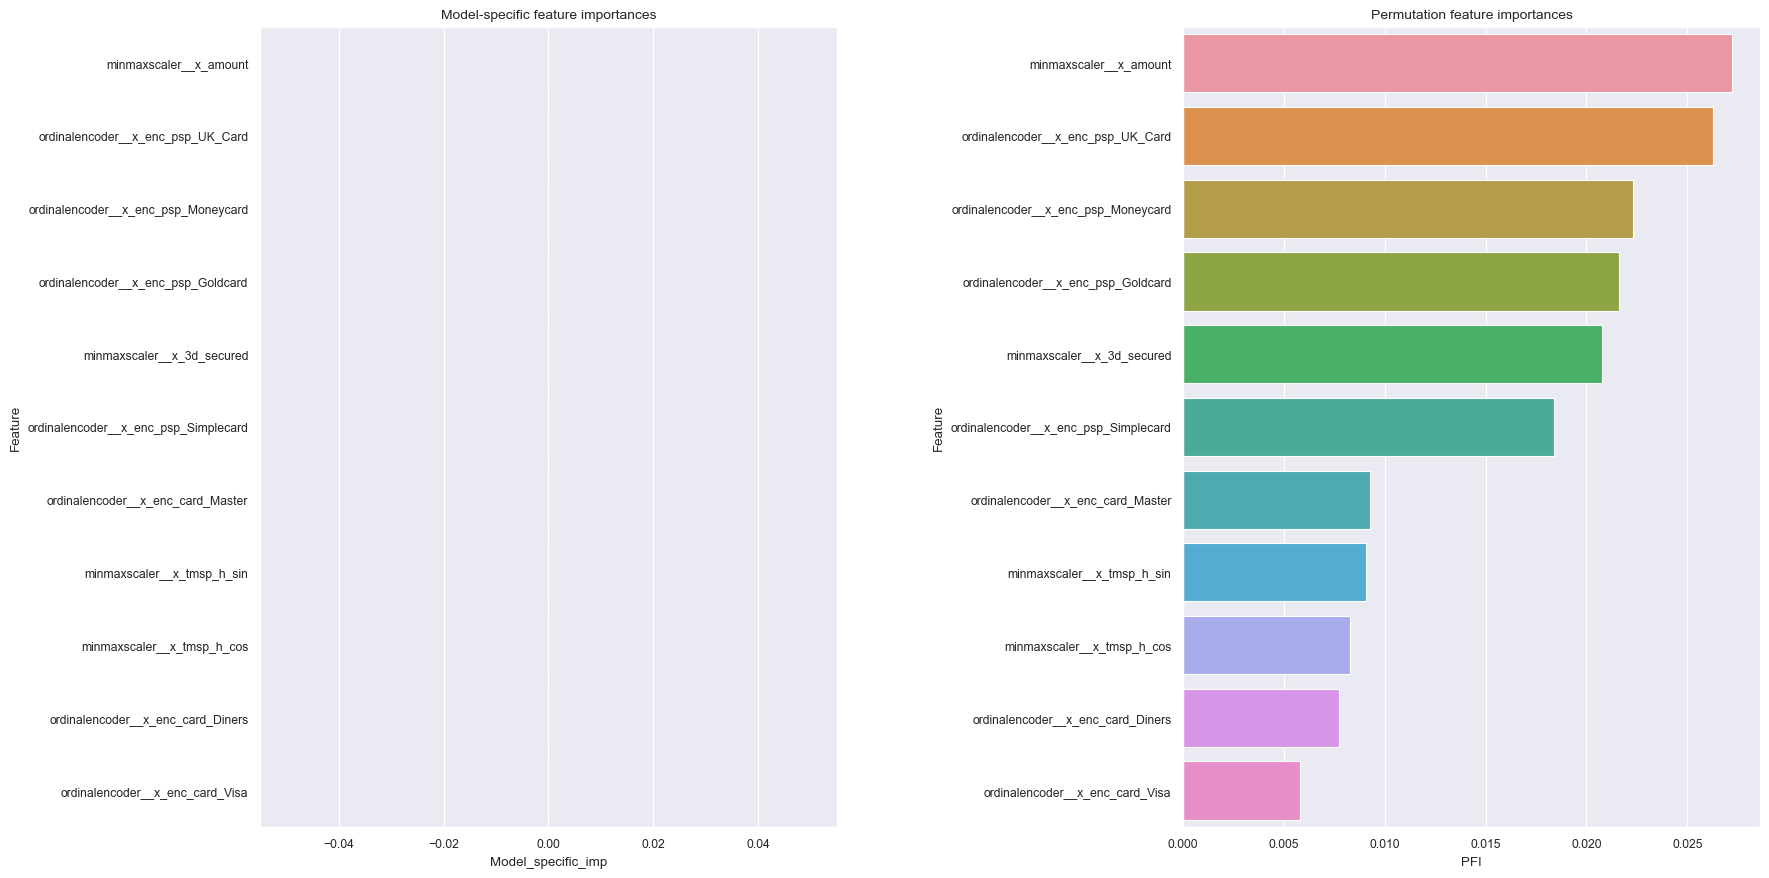

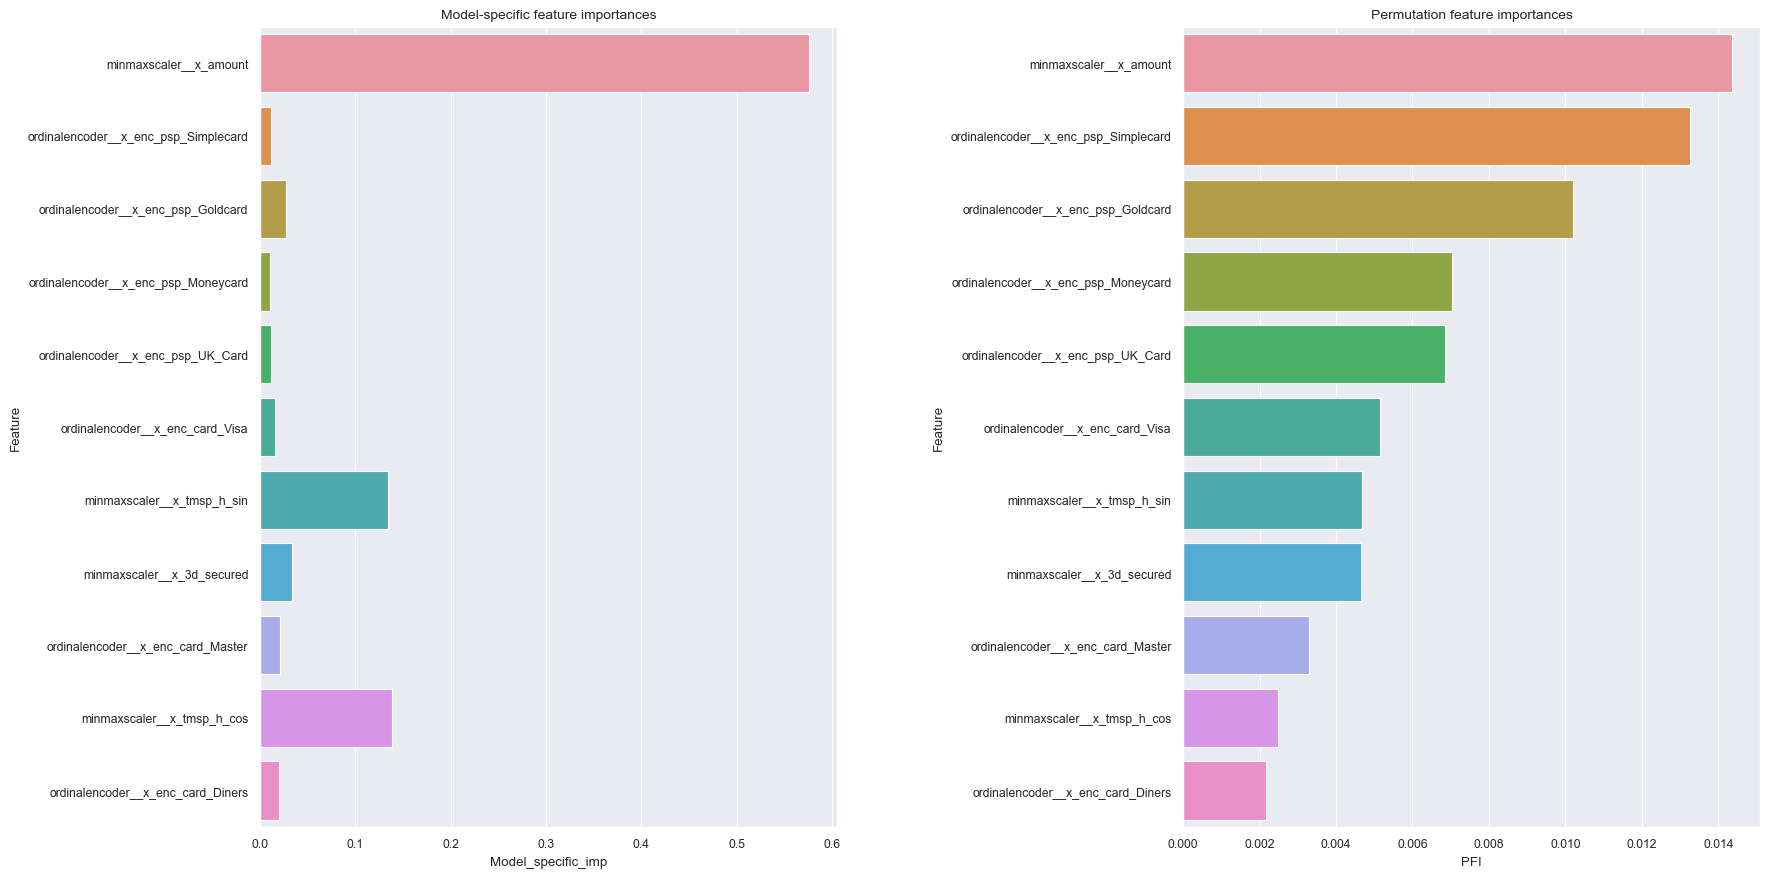

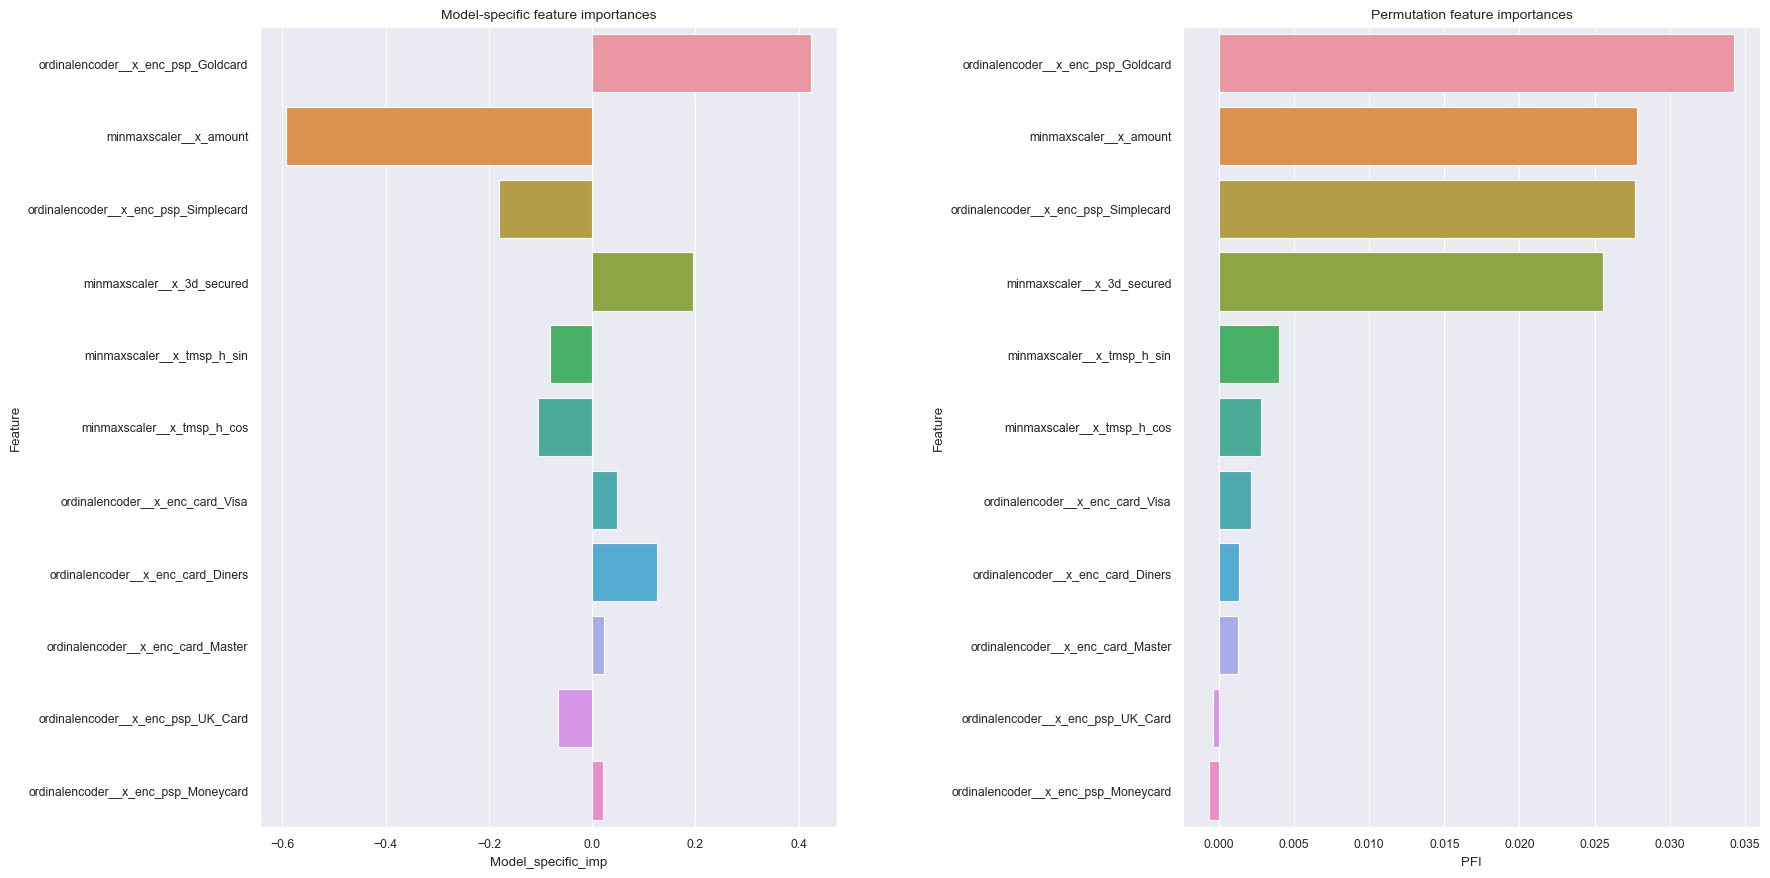

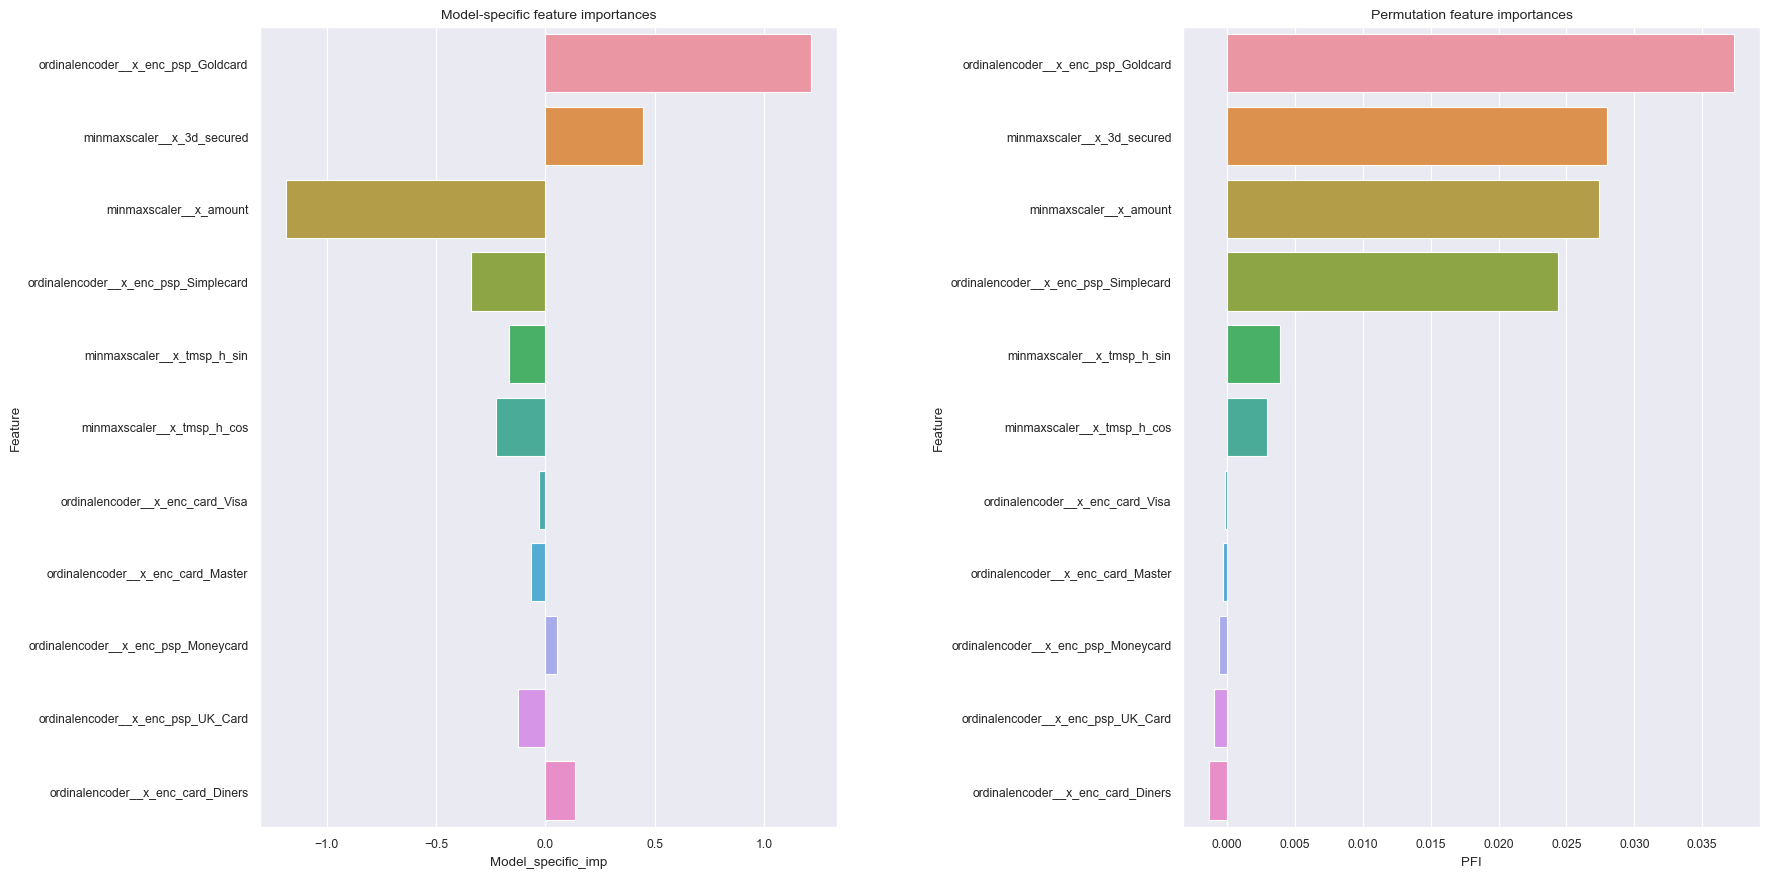

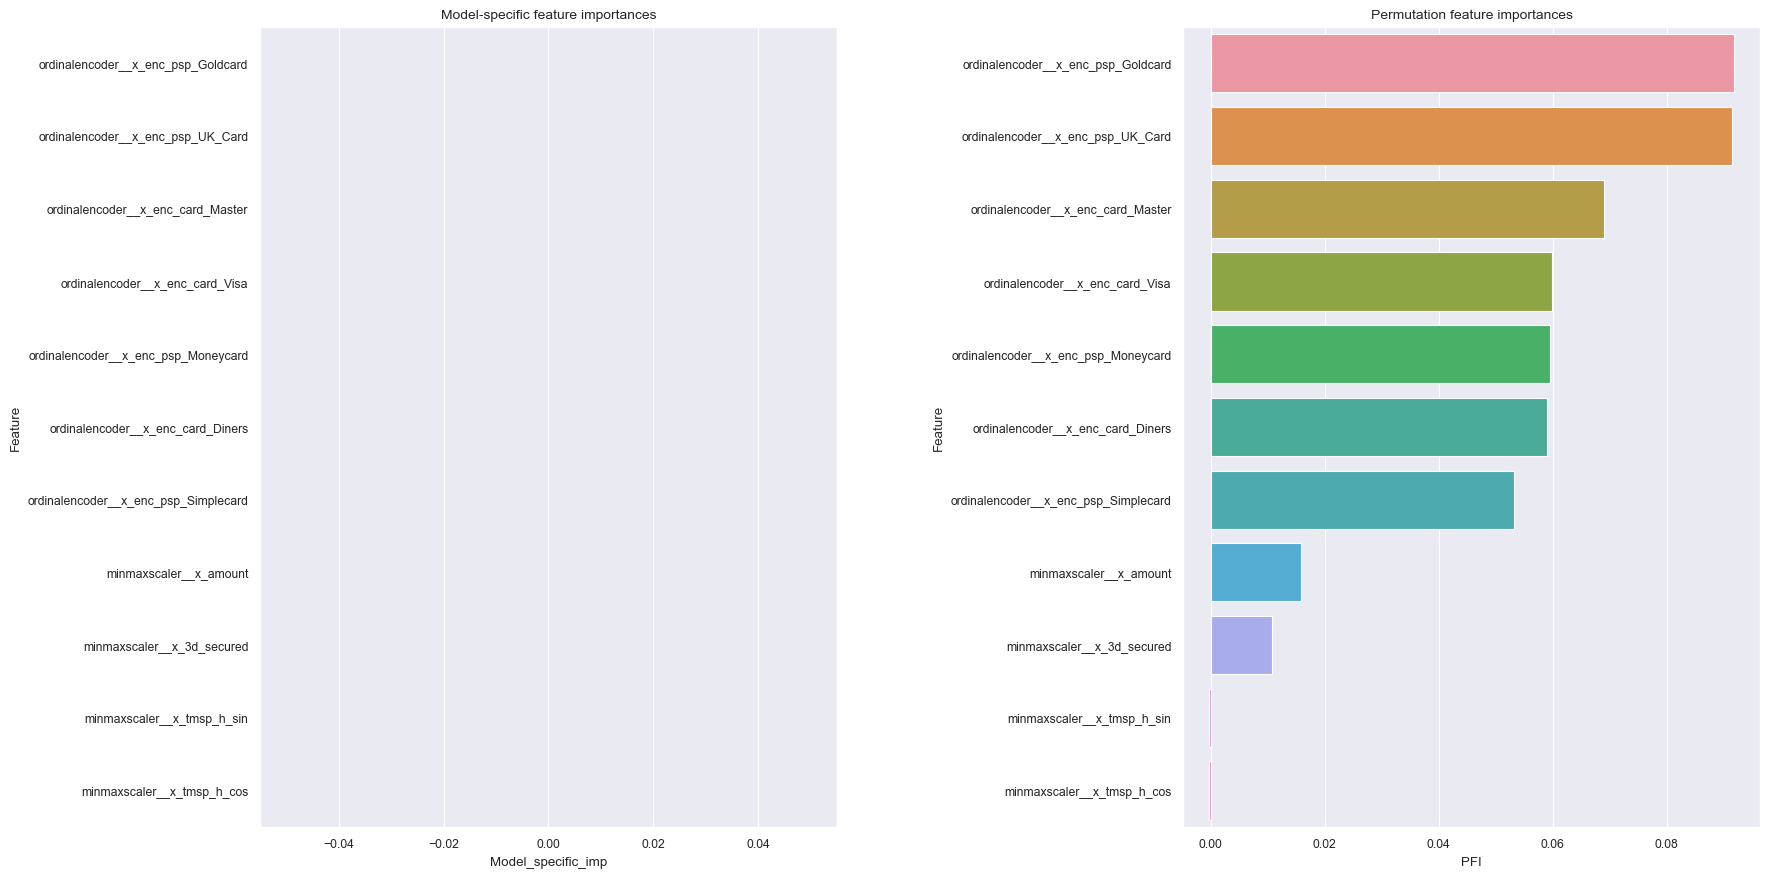

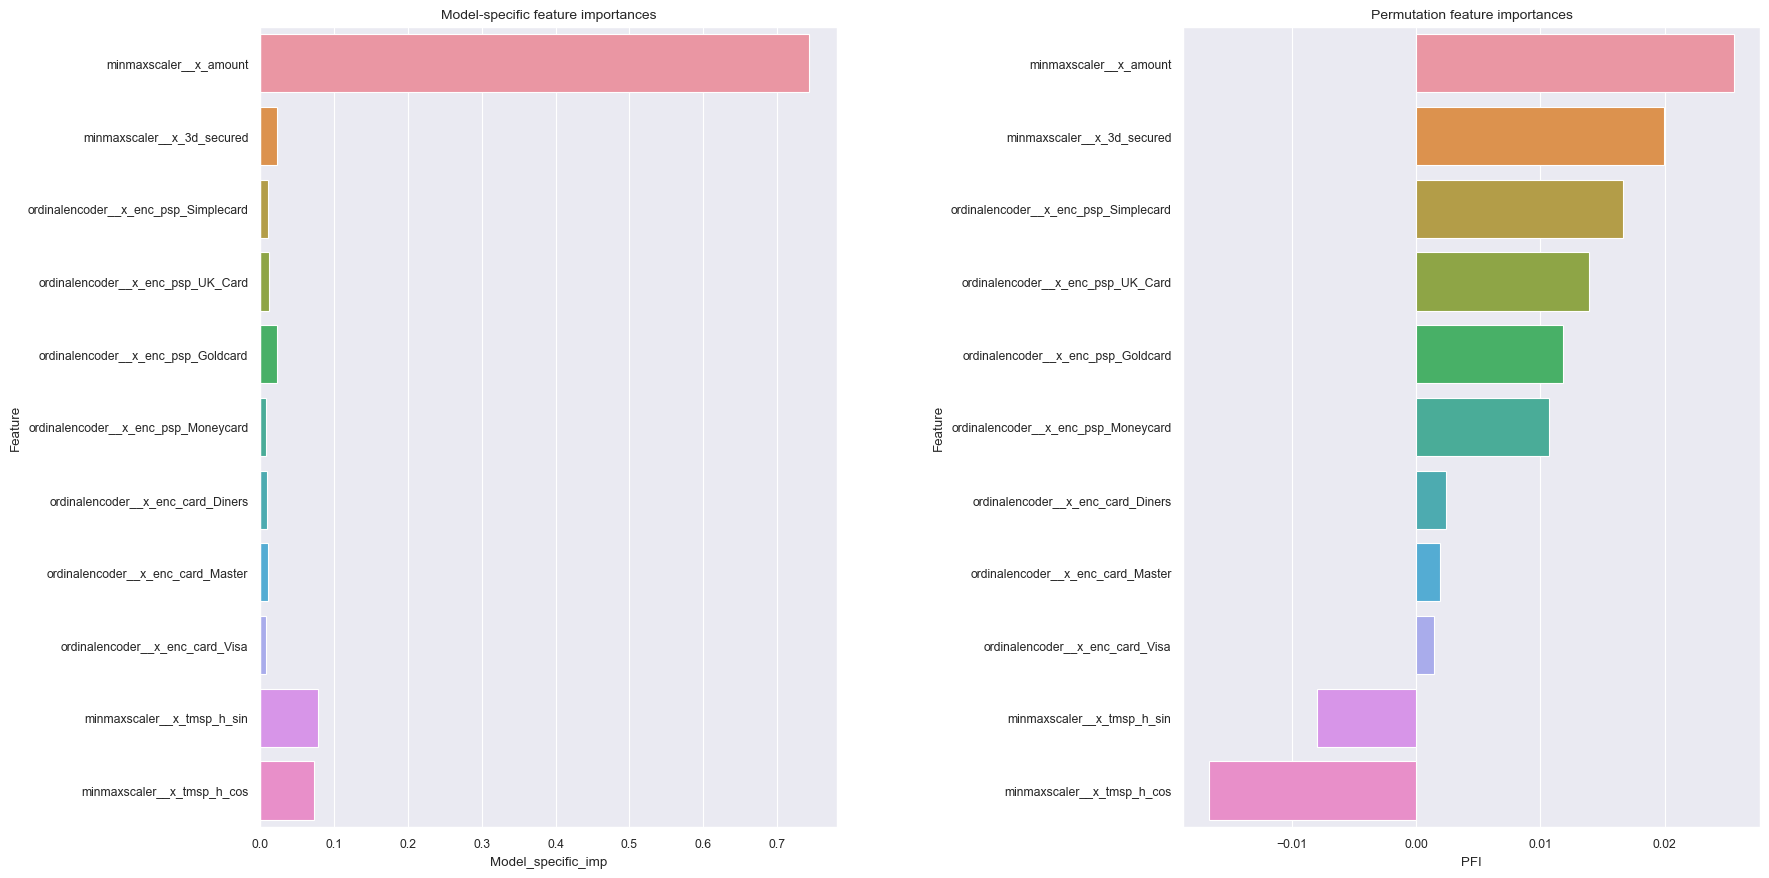

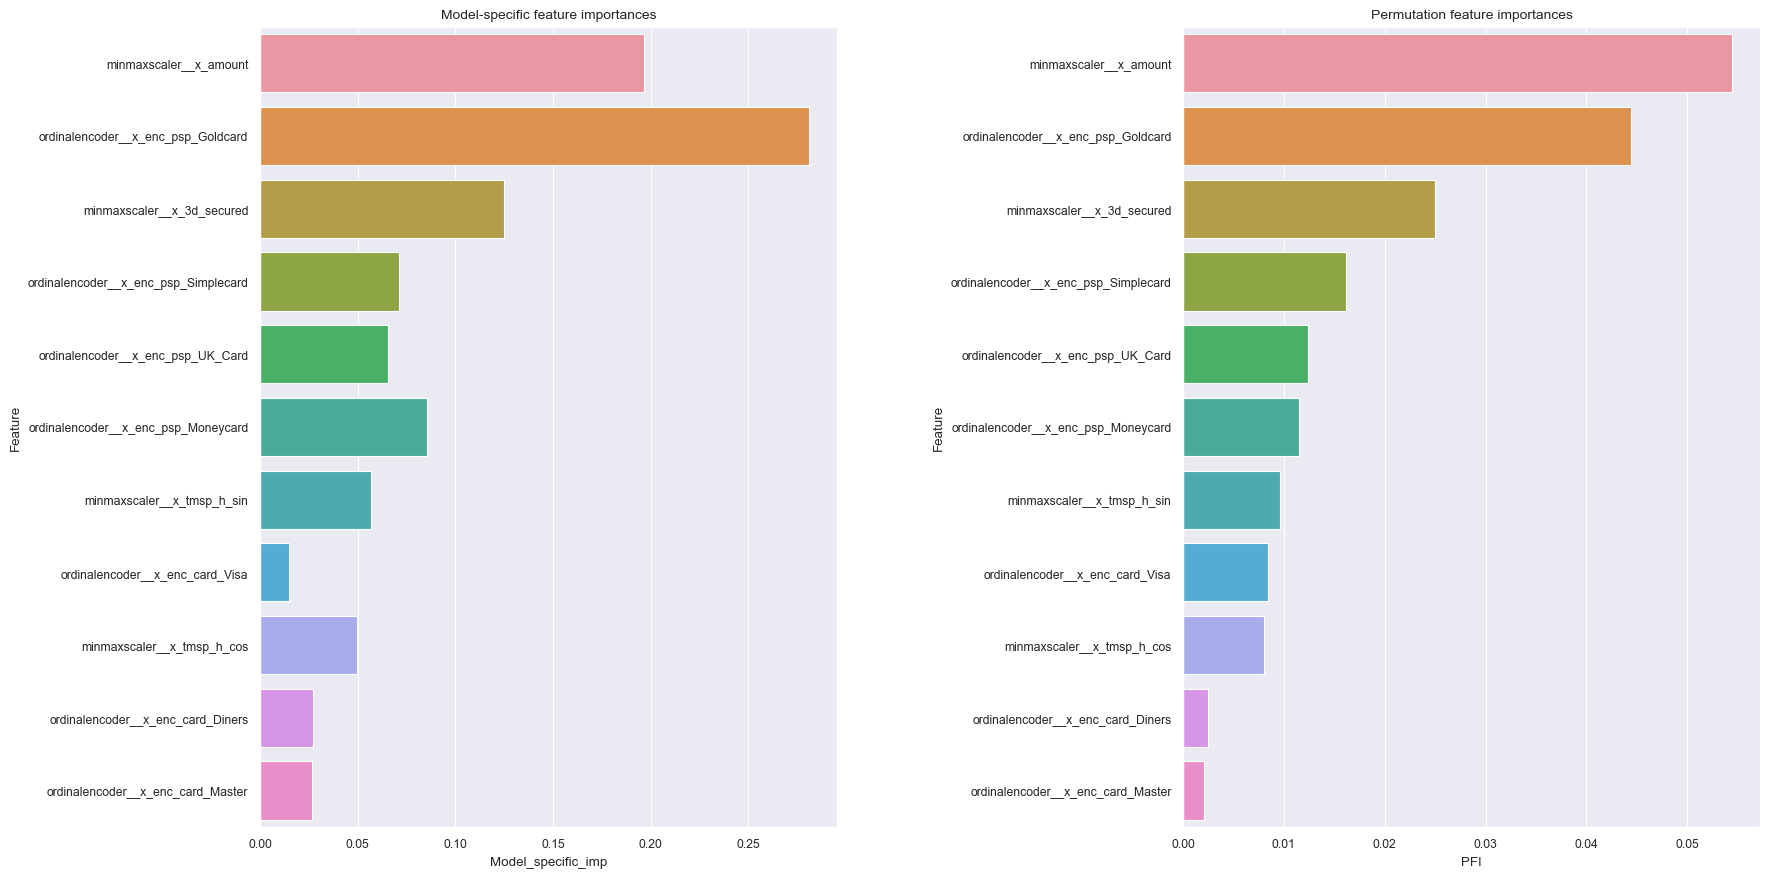

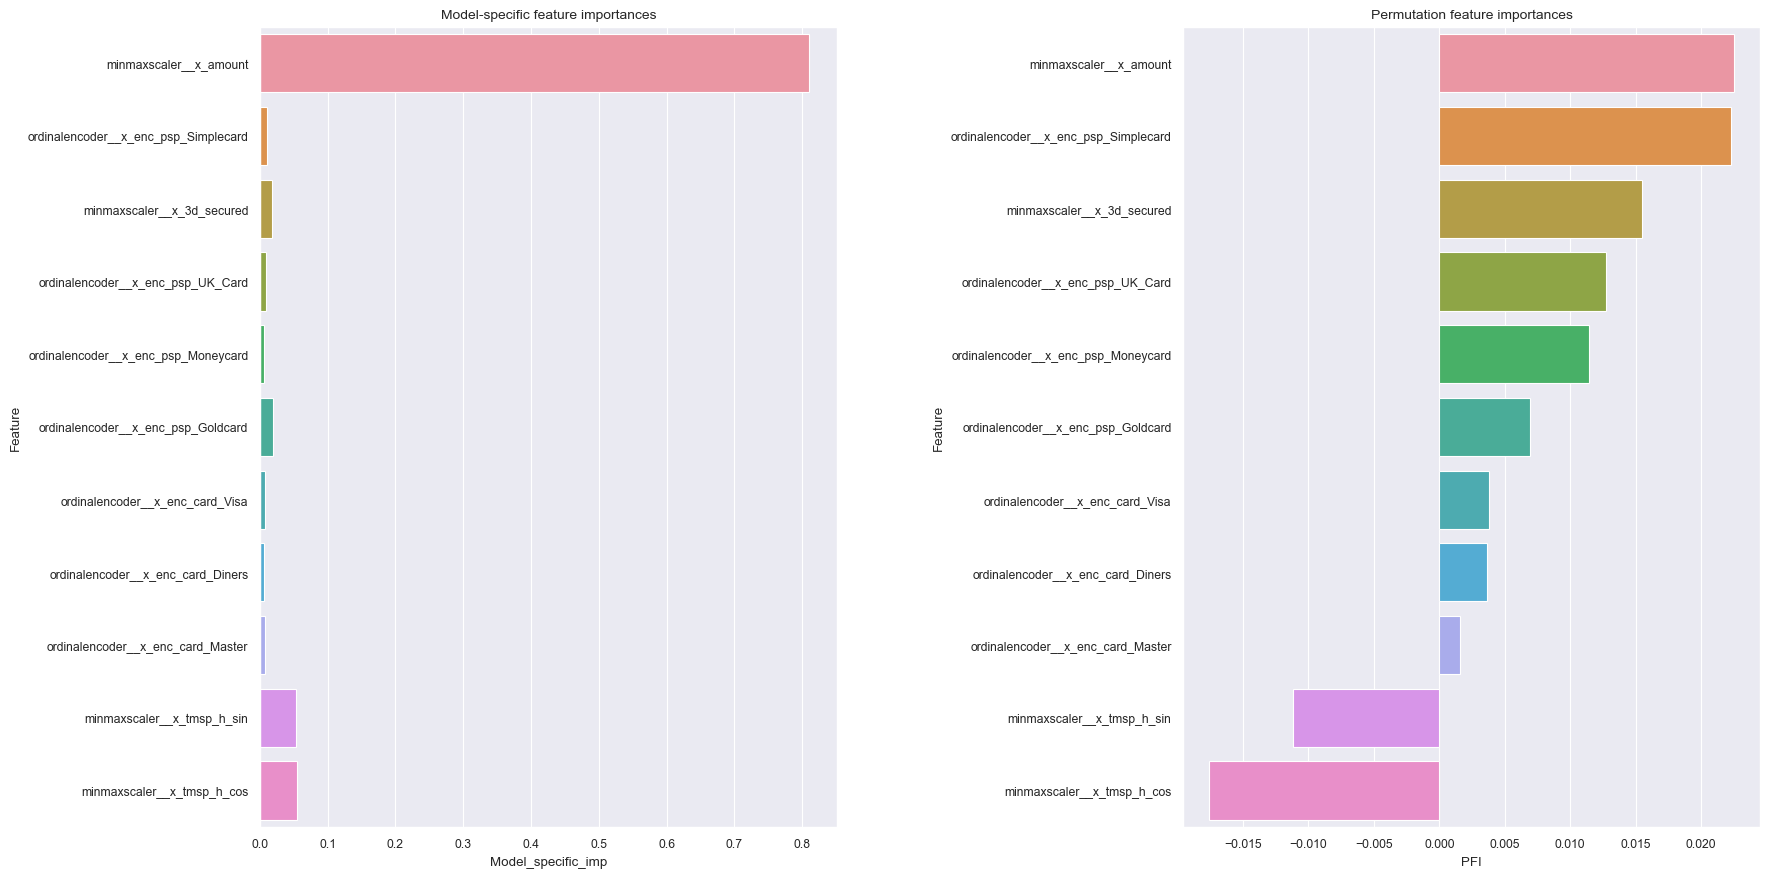

In [150]:
second_exp = "PSP_2b_w/_class_weights"
second_info = "2. Training of models w/ REDUCED features set &  WITHOUT hyperparameter tuning"
"""train_model(zip_iter=second_step_zip, 
            x_train_raw=x_train_raw_light, x_train_numerical=x_train_numerical_light, 
            x_test_raw=x_test_raw_light, x_test_numerical=x_test_numerical_light, 
            y_train=y_train, y_test=y_test,
            features_numerical=features_light, 
            exp_name=second_exp, info_text=second_info)"""

# Modeling no. 3: Random search for hyperparameter tuning
Remove:
- Dummy
- Naive Bayes due to low optimization potential
- KNN due to high computing effort

In [151]:
# collect all models
# names
third_clf_names = ["Logistic Regression", 
                    "Decision Tree", 
                    "Linear SVM",  
                    "LDA", 
                    "QDA",
                    "Random Forest", 
                    "Gradient Boosting", 
                    "Extra Trees"]

# configure parameters per model
hp_baseline = {"strategy": ["most_frequent", "stratified"]}
hp_qda = {"reg_param": np.arange(0, 1.01, 0.1)}
hp_lda = {"shrinkage": [None, "auto"]}
hp_lr = {"penalty": ["l1", "l2", "elasticnet", None], 
         "C": np.arange(0.01, 10, 0.1), 
         "l1_ratio": np.arange(0.1, 1.01, 0.1)}
hp_knn = {"n_neighbors": np.arange(5, 75, 2), 
          "weights": ["uniform", "distance"], 
          "algorithm": ["ball_tree", "kd_tree", "brute"], 
          "p": np.arange(1, 3.0, 0.1)}
hp_dt = {"criterion": ["gini", "entropy", "log_loss"], 
         "splitter": ["best", "random"], 
         "max_depth": np.arange(2, 52, 2), 
         "min_samples_split": np.arange(2, 52, 2), 
         "min_samples_leaf": np.arange(1, 32, 2)}
hp_lin_svm = {"penalty": ["l1", "l2"], 
              "C": np.arange(0, 15, 0.5)}
hp_rf = {"n_estimators": np.arange(10, 300, 20), 
         "criterion": ["gini", "entropy", "log_loss"], 
         "max_depth": np.arange(2, 60, 2), 
         "min_samples_split": np.arange(2, 50, 2), 
         "min_samples_leaf": np.arange(1, 30, 2), 
         "max_features": [None, "sqrt", "log2"]}
hp_grad_boost = {"loss": ["log_loss", "exponential"], 
                 "learning_rate":np.arange(0.1, 1.5, 0.1), 
                 "subsample": np.arange(0.3, 0.99, 0.1), 
                 "criterion": ["friedman_mse", "squared_error"], 
                 "min_samples_split": np.arange(2, 50, 2), 
                 "min_samples_leaf": np.arange(1, 30, 2), 
                 "max_depth": np.arange(2, 20, 1), 
                 "max_features": [None, "sqrt", "log2"]}
hp_extra = {"criterion": ["gini", "entropy", "log_loss"], 
            "max_depth": np.arange(2, 60, 2), 
            "min_samples_split": np.arange(2, 52, 2), 
            "min_samples_leaf": np.arange(1, 32, 2), 
            "max_features": [None, "sqrt", "log2"], 
            "min_weight_fraction_leaf": np.arange(0, 0.5, 0.1), 
            "bootstrap": [True, False]}

# parameters collected
third_params = [hp_lr, hp_dt, hp_lin_svm, hp_lda, hp_qda, hp_rf, hp_grad_boost, hp_extra]

# sklearn models
third_clf = [LogisticRegression(solver="saga", class_weight="balanced", **params_rs),  
              DecisionTreeClassifier(class_weight="balanced", **params_rs),
              LinearSVC(dual="auto", class_weight="balanced", **params_rs), 
              LinearDiscriminantAnalysis(solver="lsqr"), 
              QuadraticDiscriminantAnalysis(),
              RandomForestClassifier(class_weight="balanced_subsample", **params_rs), 
              GradientBoostingClassifier(**params_rs), 
              ExtraTreesClassifier(class_weight="balanced_subsample", **params_rs)]

# feature mode for model
third_feat_mode = ["numeric", 
                    "numeric", 
                    "numeric", 
                    "numeric", 
                    "numeric", 
                    "numeric", 
                    "numeric", 
                    "numeric"]

third_zip = zip(third_clf_names, third_clf, third_params, third_feat_mode)
print(f"length of clf_names {len(third_clf_names)} & clf {len(third_clf)} & parameters {len(third_params)} & feat_mode {len(third_feat_mode)}")

length of clf_names 8 & clf 8 & parameters 8 & feat_mode 8


Training and logging of model Logistic Regression as classifier LogisticRegression(class_weight='balanced', random_state=23, solver='saga') with feature mode numeric
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...C=1.4100000000000001, l1_ratio=0.9, penalty=None; total time=   0.4s
[CV] END ...C=1.4100000000000001, l1_ratio=0.9, penalty=None; total time=   0.4s
[CV] END ...C=1.4100000000000001, l1_ratio=0.9, penalty=None; total time=   0.3s
[CV] END ...C=1.4100000000000001, l1_ratio=0.9, penalty=None; total time=   0.3s
[CV] END ...C=1.4100000000000001, l1_ratio=0.9, penalty=None; total time=   0.4s
[CV] END ...........C=1.81, l1_ratio=0.6, penalty=elasticnet; total time=   0.4s
[CV] END ...........C=1.81, l1_ratio=0.6, penalty=elasticnet; total time=   0.4s
[CV] END ...........C=1.81, l1_ratio=0.6, penalty=elasticnet; total time=   0.6s
[CV] END ...........C=1.81, l1_ratio=0.6, penalty=elasticnet; total time=   0.5s
[CV] END ...........C=1.81, l1_ratio=0.6, p

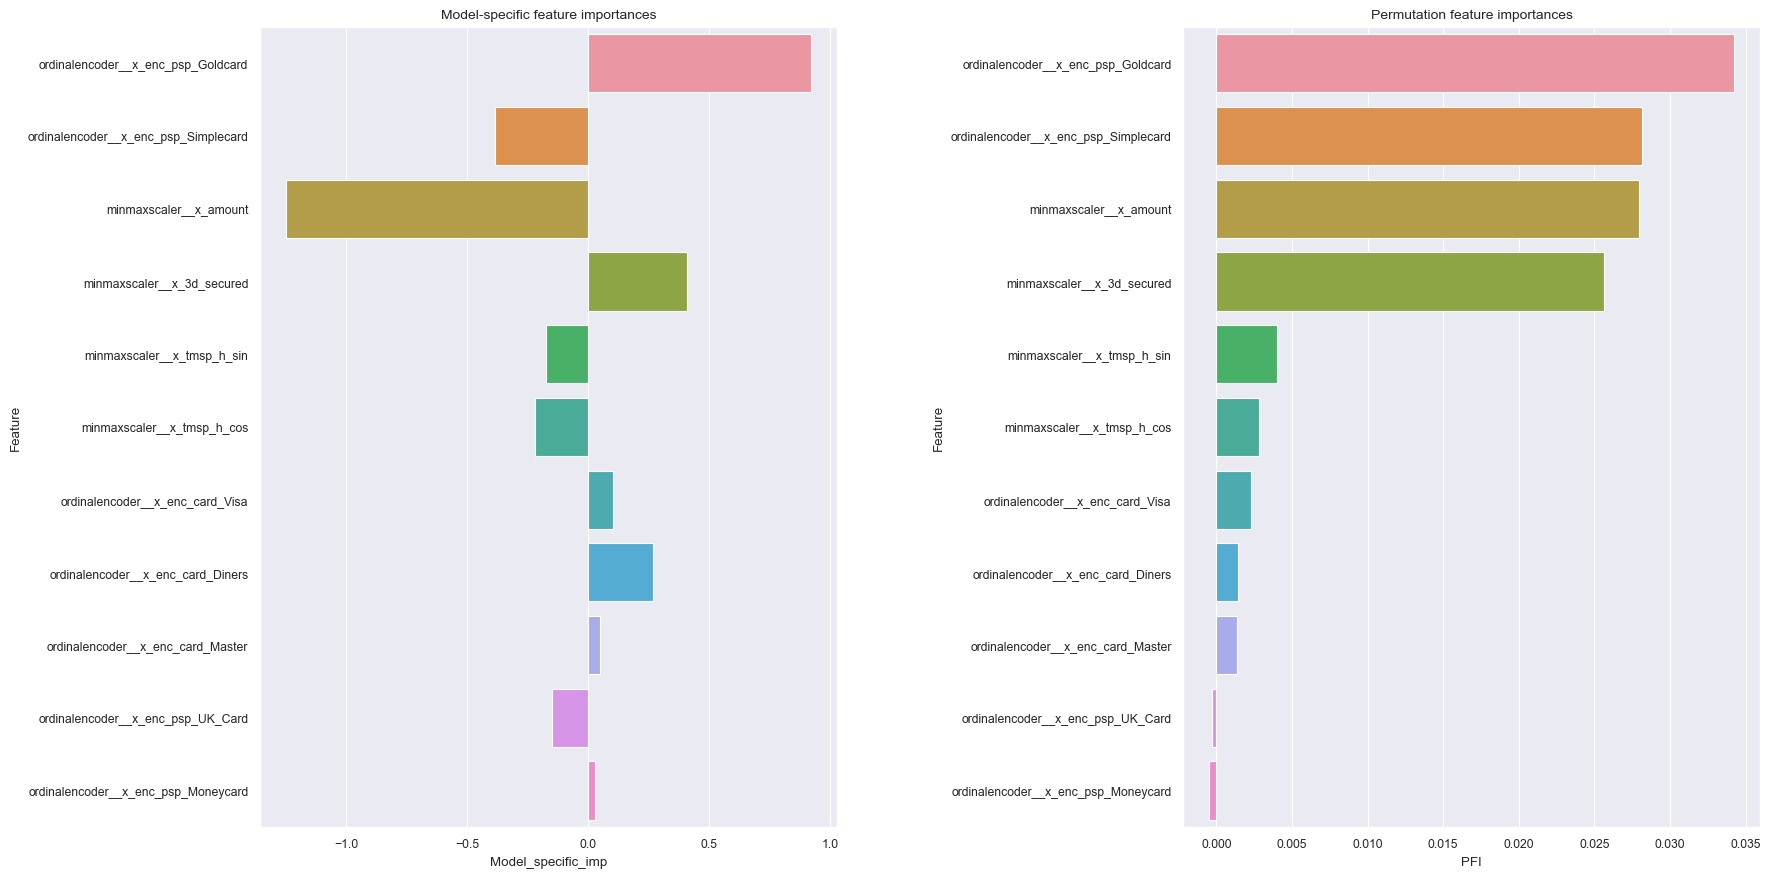

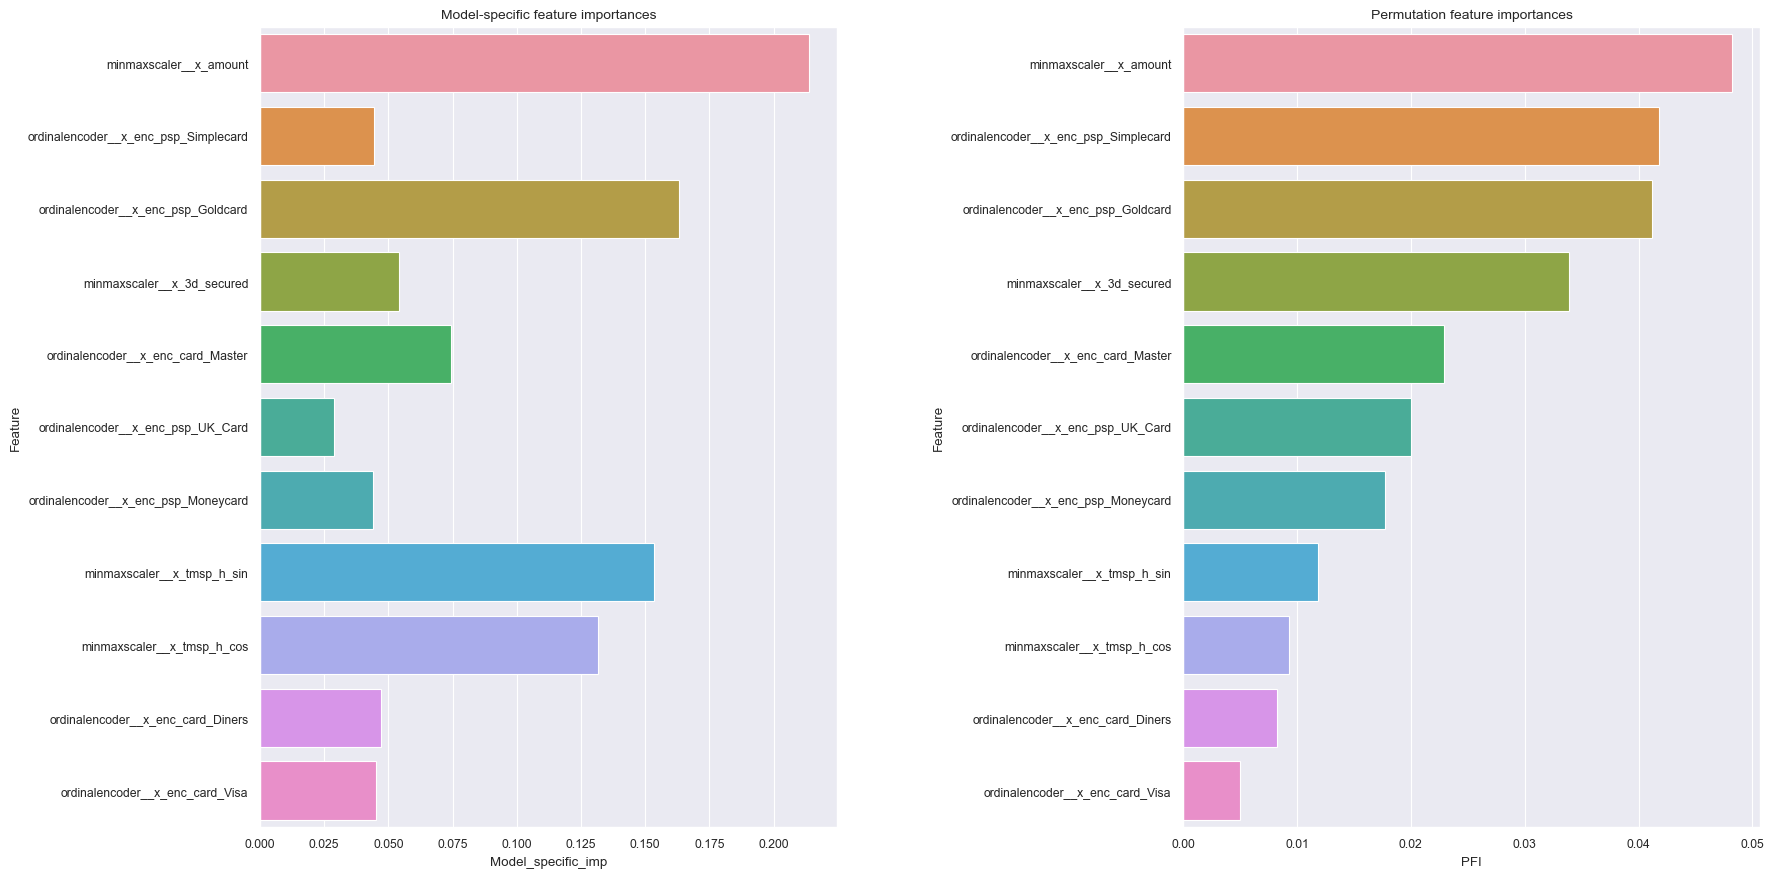

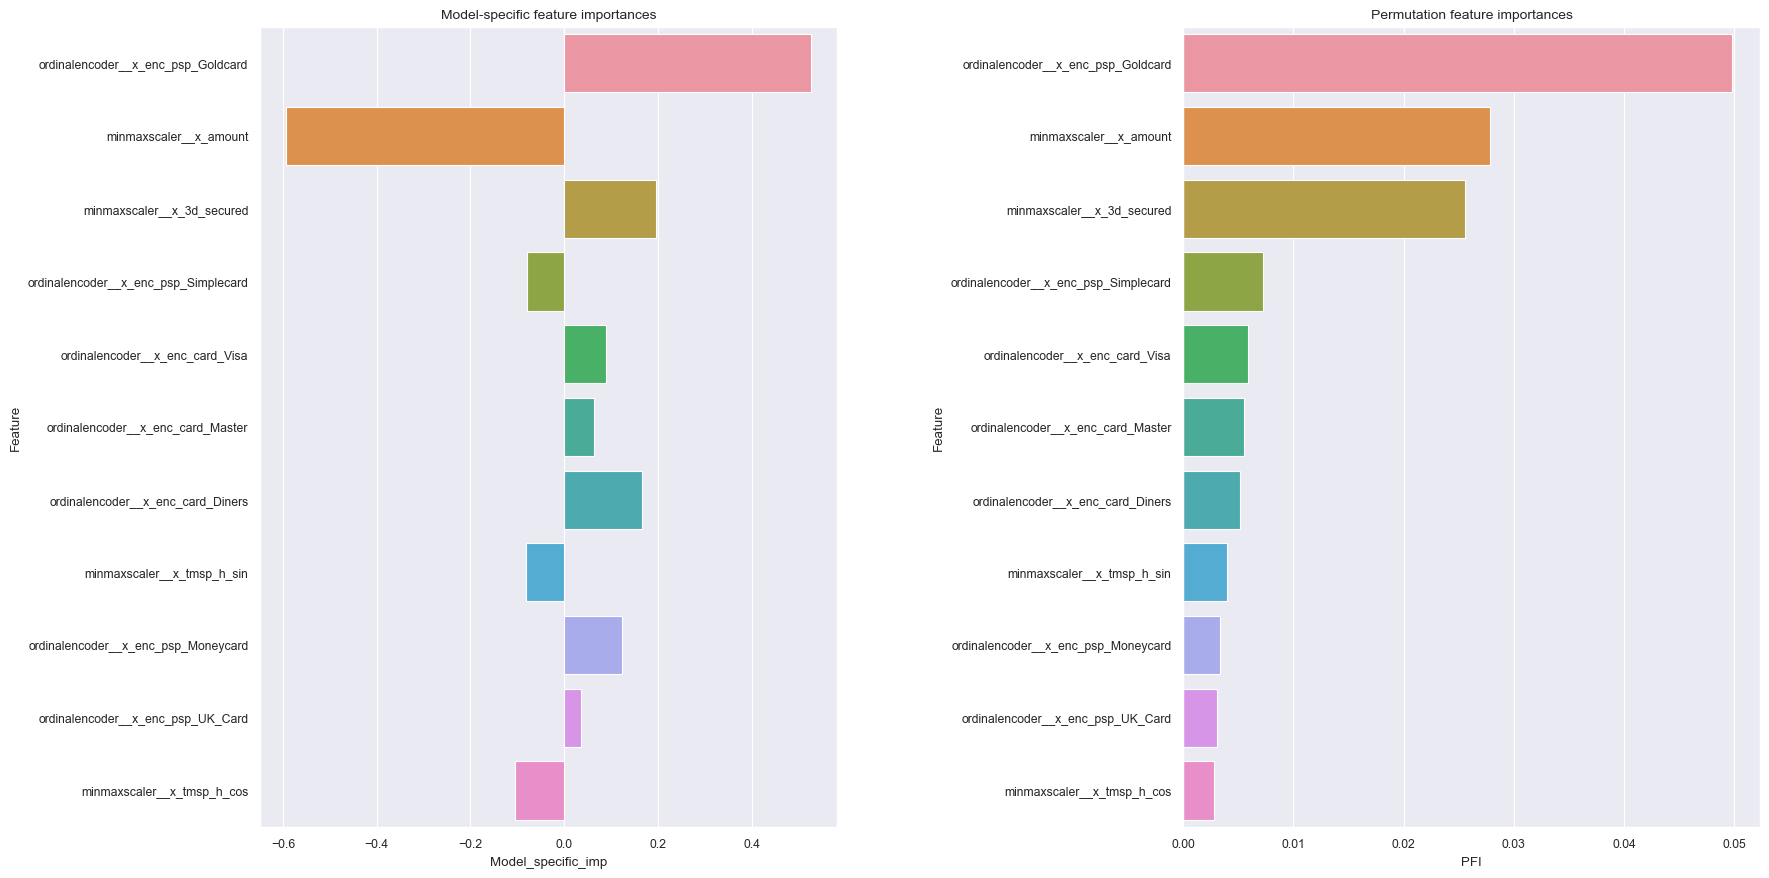

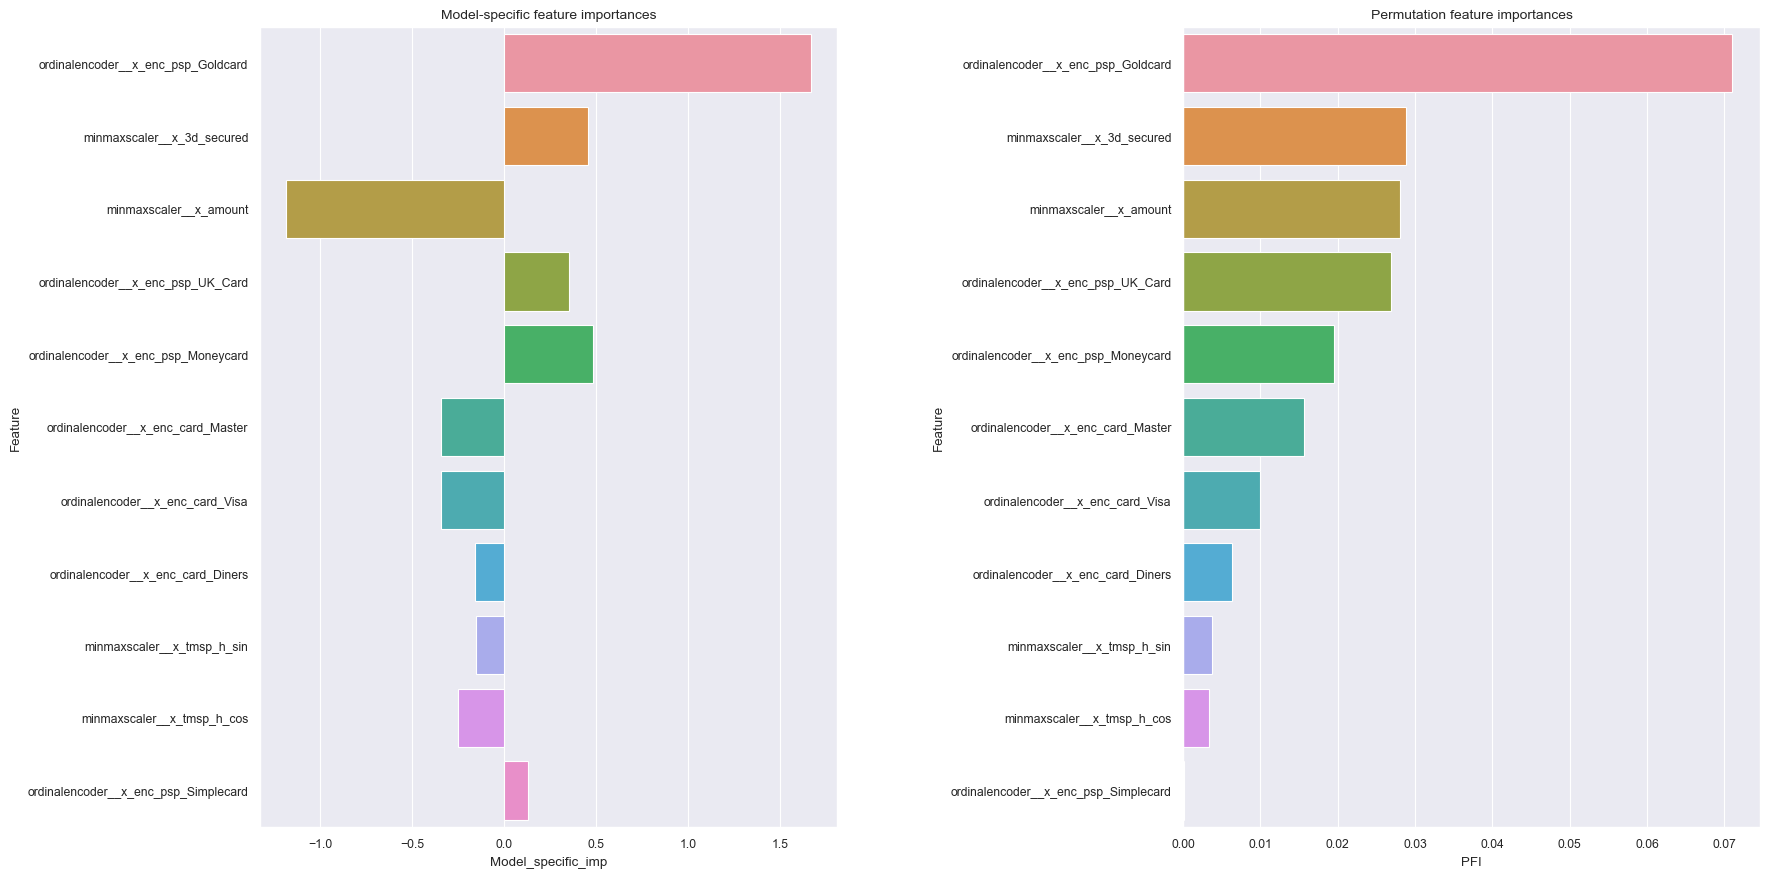

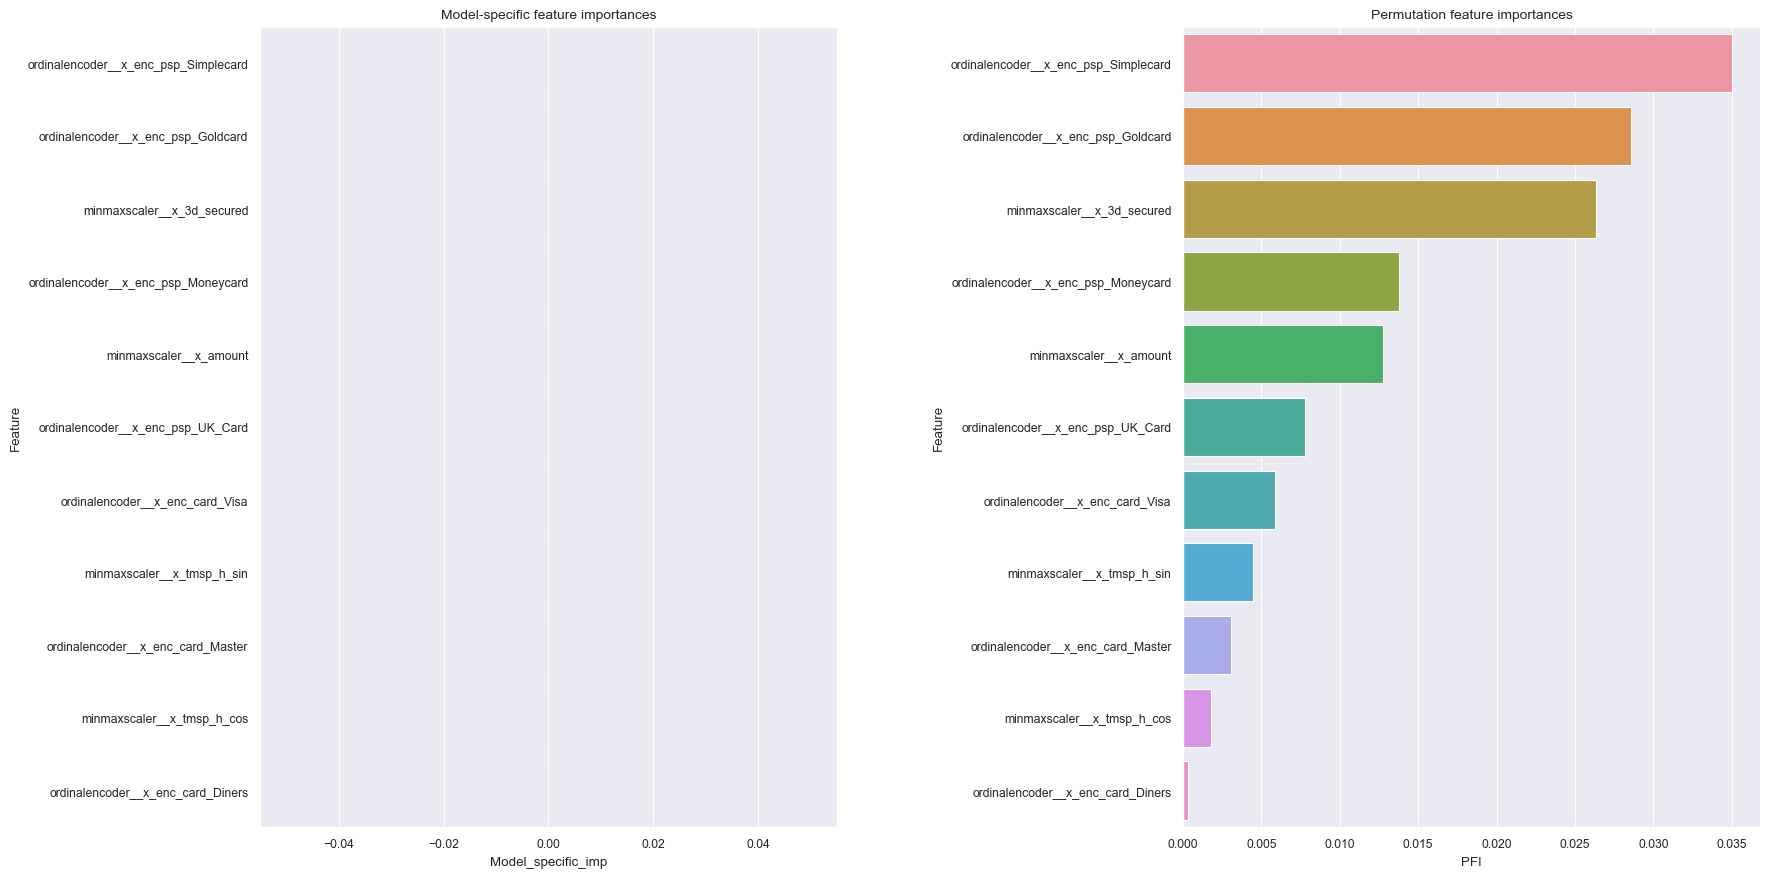

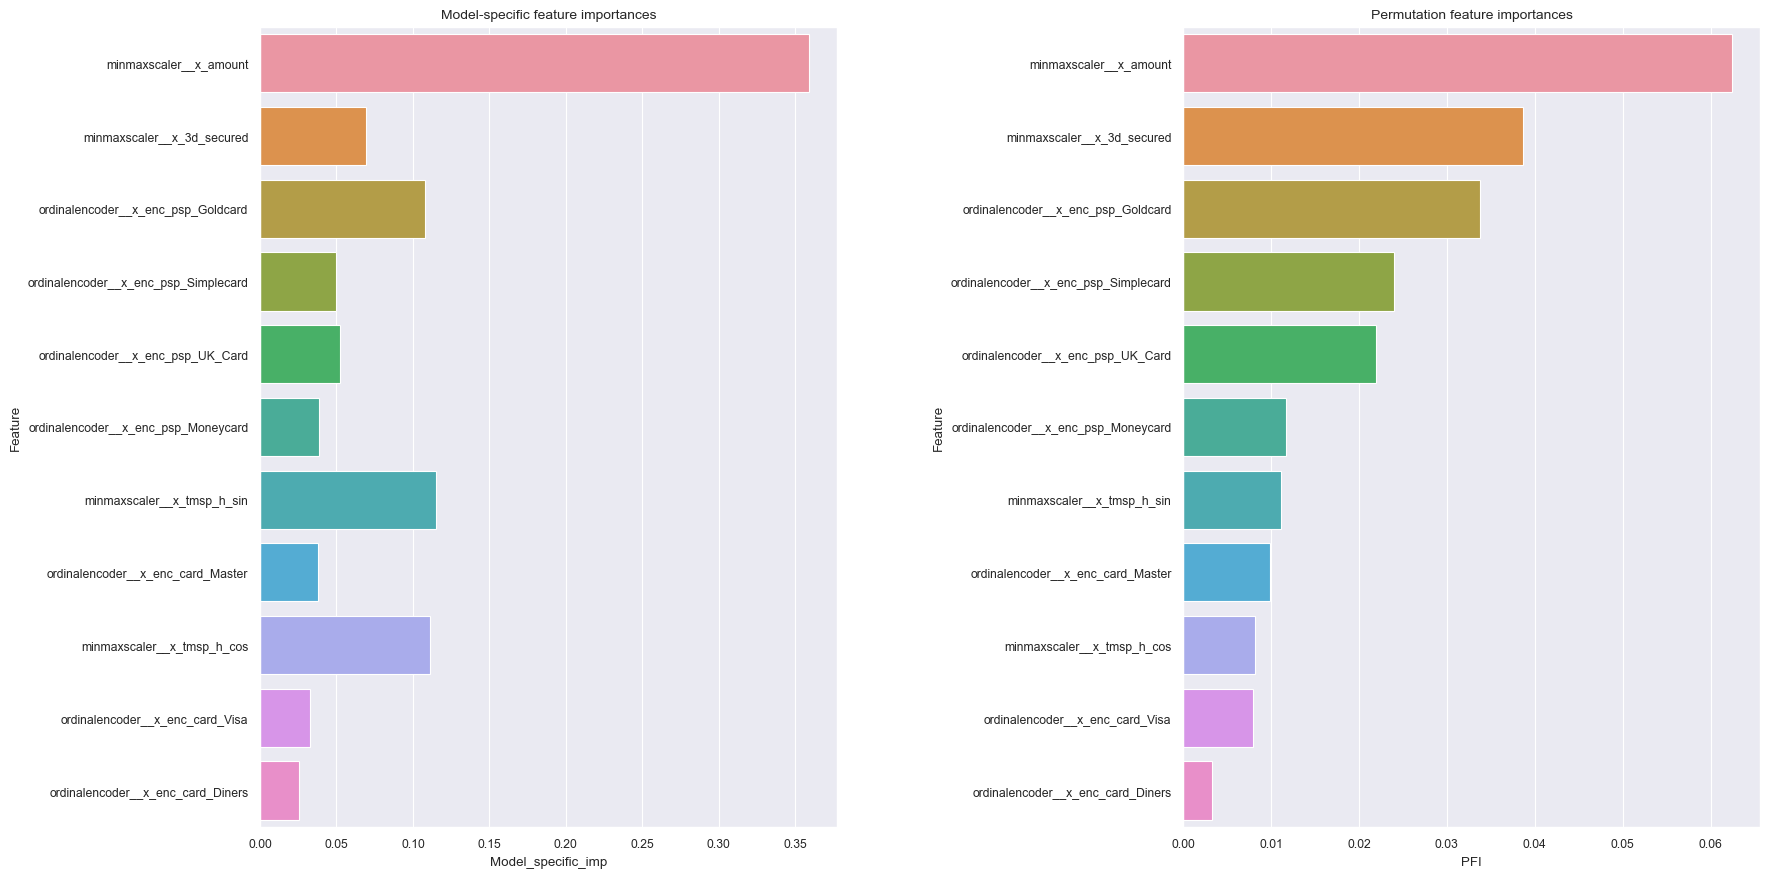

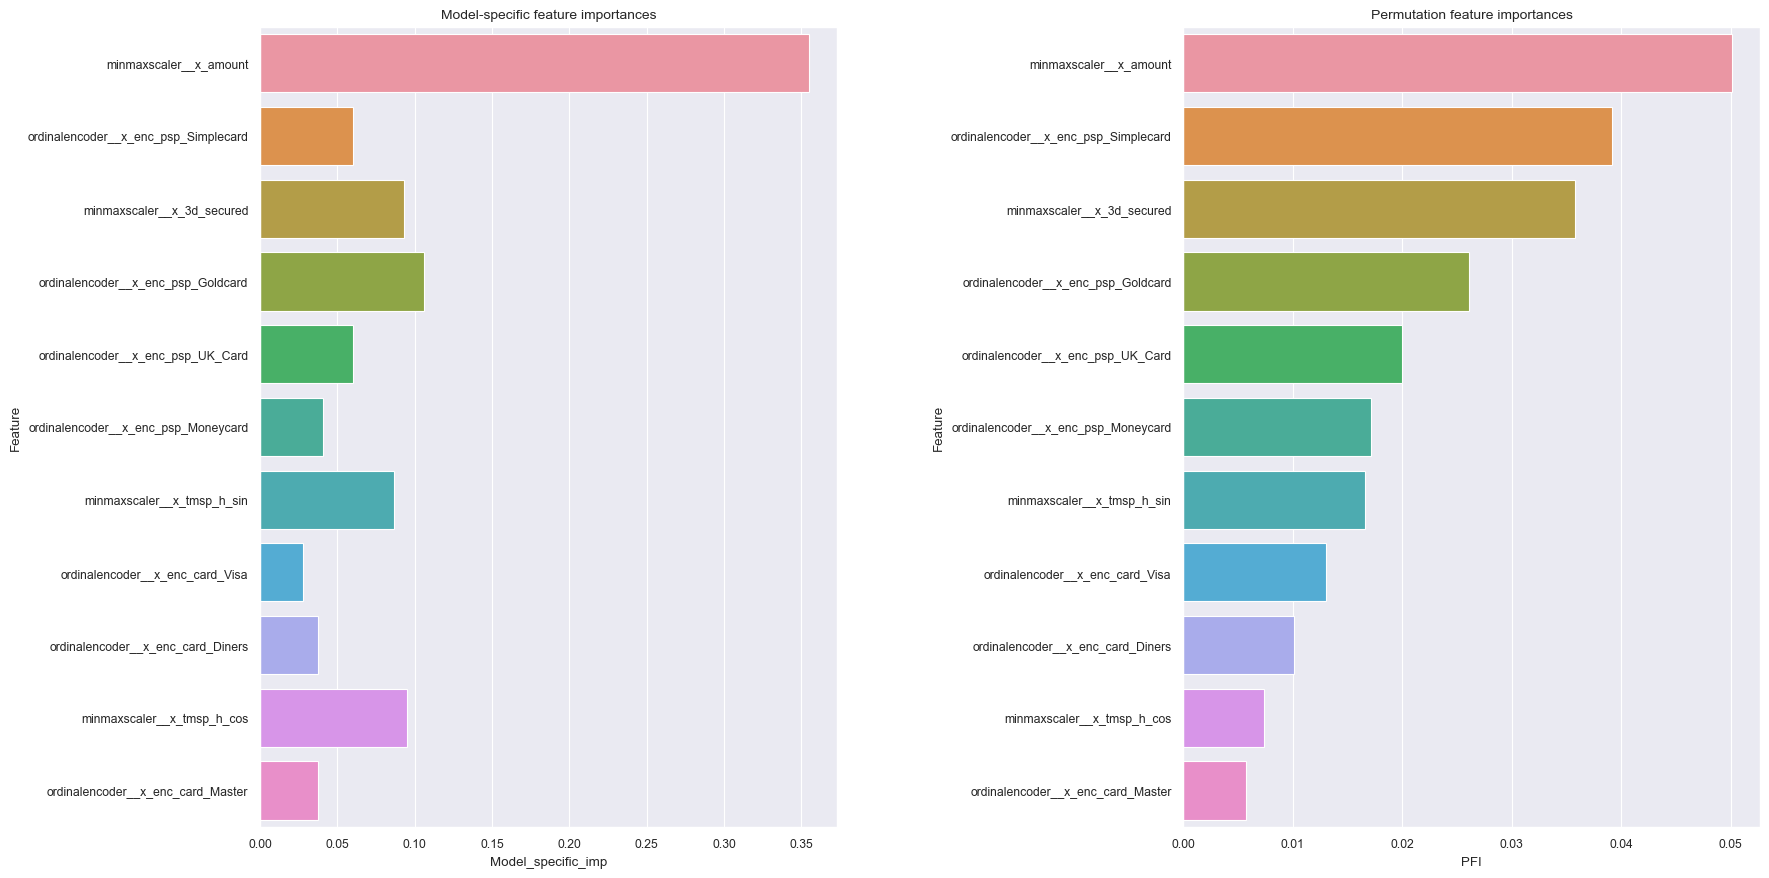

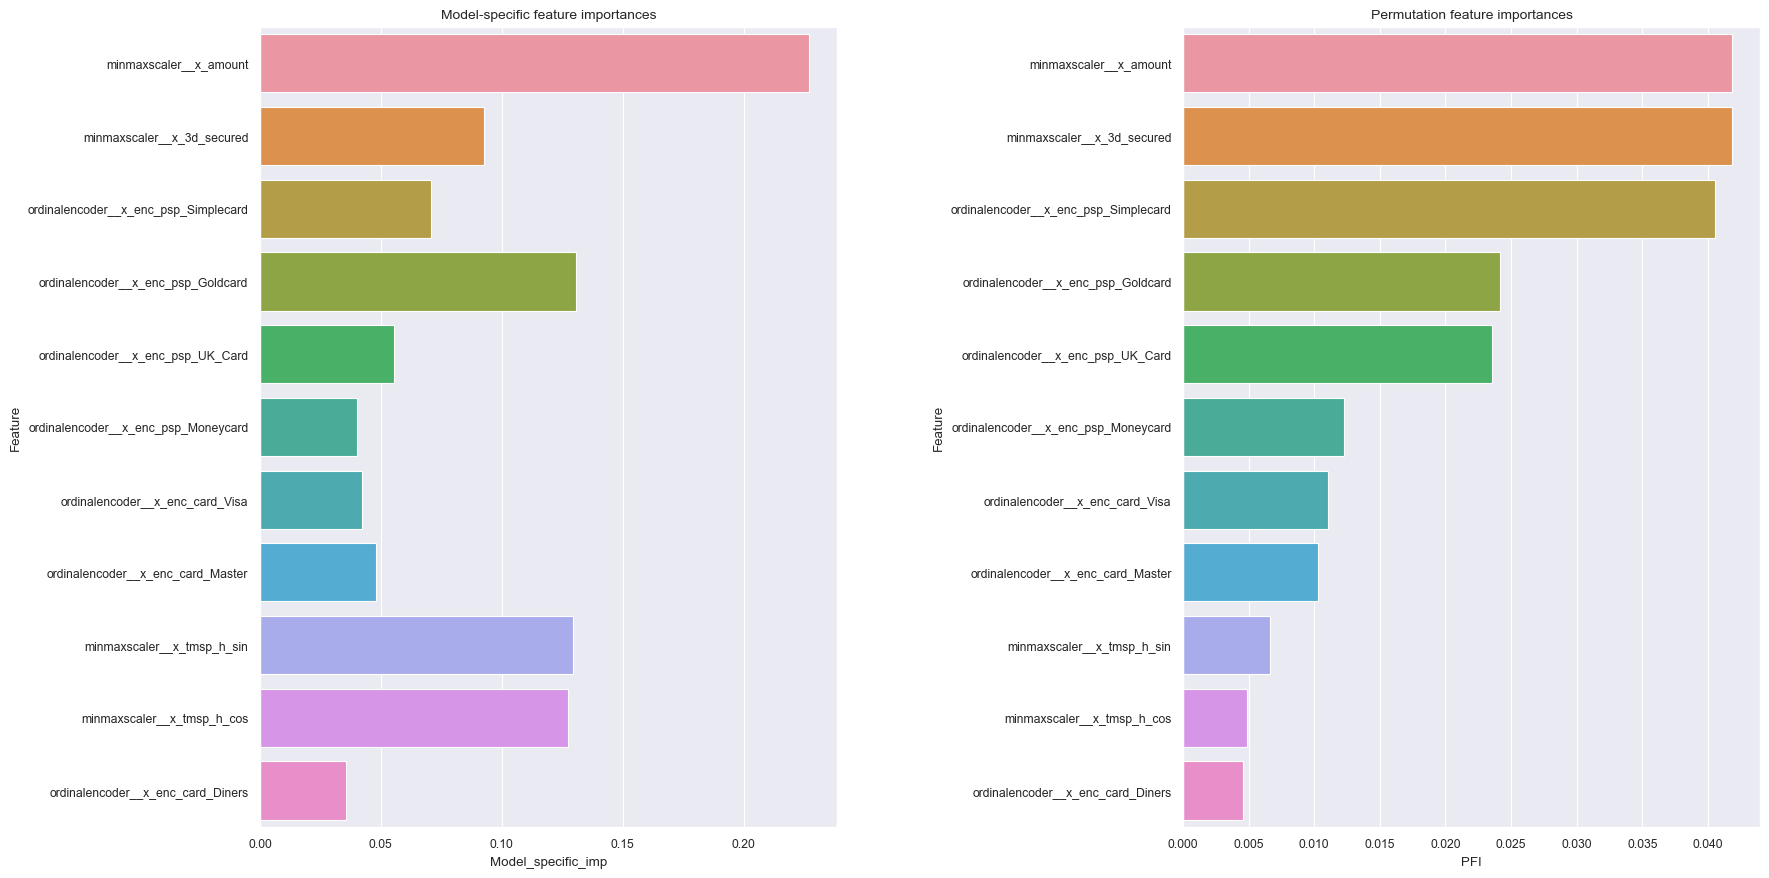

In [152]:
third_exp = "PSP_3b_HP-tune_w/_class_weights"
third_info = "3. Training of models WITH hyperparameter tuning & w/ REDUCED features set "
"""hp_tune_model(search_mode="random", 
              zip_iter=third_zip, 
              x_train_raw=x_train_raw_light, x_train_numerical=x_train_numerical_light, 
              x_test_raw=x_test_raw_light, x_test_numerical=x_test_numerical_light, 
              y_train=y_train, y_test=y_test, 
              features_numerical=features_light, 
              exp_name=third_exp, info_text=third_info)"""

# Modeling no. 4: Fine-tuning of Top2-models via GridSearch & pick best

In [154]:
# collect all models
# names
fourth_clf_names = ["Random Forest", "Extra Trees"]

# configure parameters per model
hp_fine_rf = {"max_depth": np.arange(25, 45, 1)}
hp_fine_extra = {"max_depth": np.arange(5, 20, 1)}

# parameters collected
fourth_params = [hp_fine_rf, hp_fine_extra]

# sklearn models
fourth_clf = [RandomForestClassifier(class_weight="balanced_subsample", 
                                     bootstrap=True, n_estimators=130,
                                     min_samples_split=2, min_samples_leaf=29,
                                     criterion="log_loss", max_features="sqrt", 
                                     random_state=rs), 
              ExtraTreesClassifier(class_weight="balanced_subsample", criterion="gini", 
                                   min_samples_split=32, min_samples_leaf=7, 
                                   max_features="sqrt", min_weight_fraction_leaf=0, 
                                   bootstrap=True, random_state=rs)]

# feature mode for model
fourth_feat_mode = ["numeric", "numeric"]

fourth_zip = zip(fourth_clf_names, fourth_clf, fourth_params, fourth_feat_mode)
print(f"length of clf_names {len(fourth_clf_names)} & clf {len(fourth_clf)} & parameters {len(fourth_params)} & feat_mode {len(fourth_feat_mode)}")

length of clf_names 2 & clf 2 & parameters 2 & feat_mode 2


Training and logging of model Random Forest as classifier RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       min_samples_leaf=29, n_estimators=130, random_state=23) with feature mode numeric
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .......................................max_depth=35; total time=   4.1s
[CV] END .......................................max_depth=35; total time=   4.5s
[CV] END .......................................max_depth=35; total time=   4.3s
[CV] END .......................................max_depth=35; total time=   4.3s
[CV] END .......................................max_depth=35; total time=   3.6s
[CV] END .......................................max_depth=36; total time=   4.8s
[CV] END .......................................max_depth=36; total time=   4.6s
[CV] END .......................................max_depth=36; total time=   4.5s
[CV] END ......................................

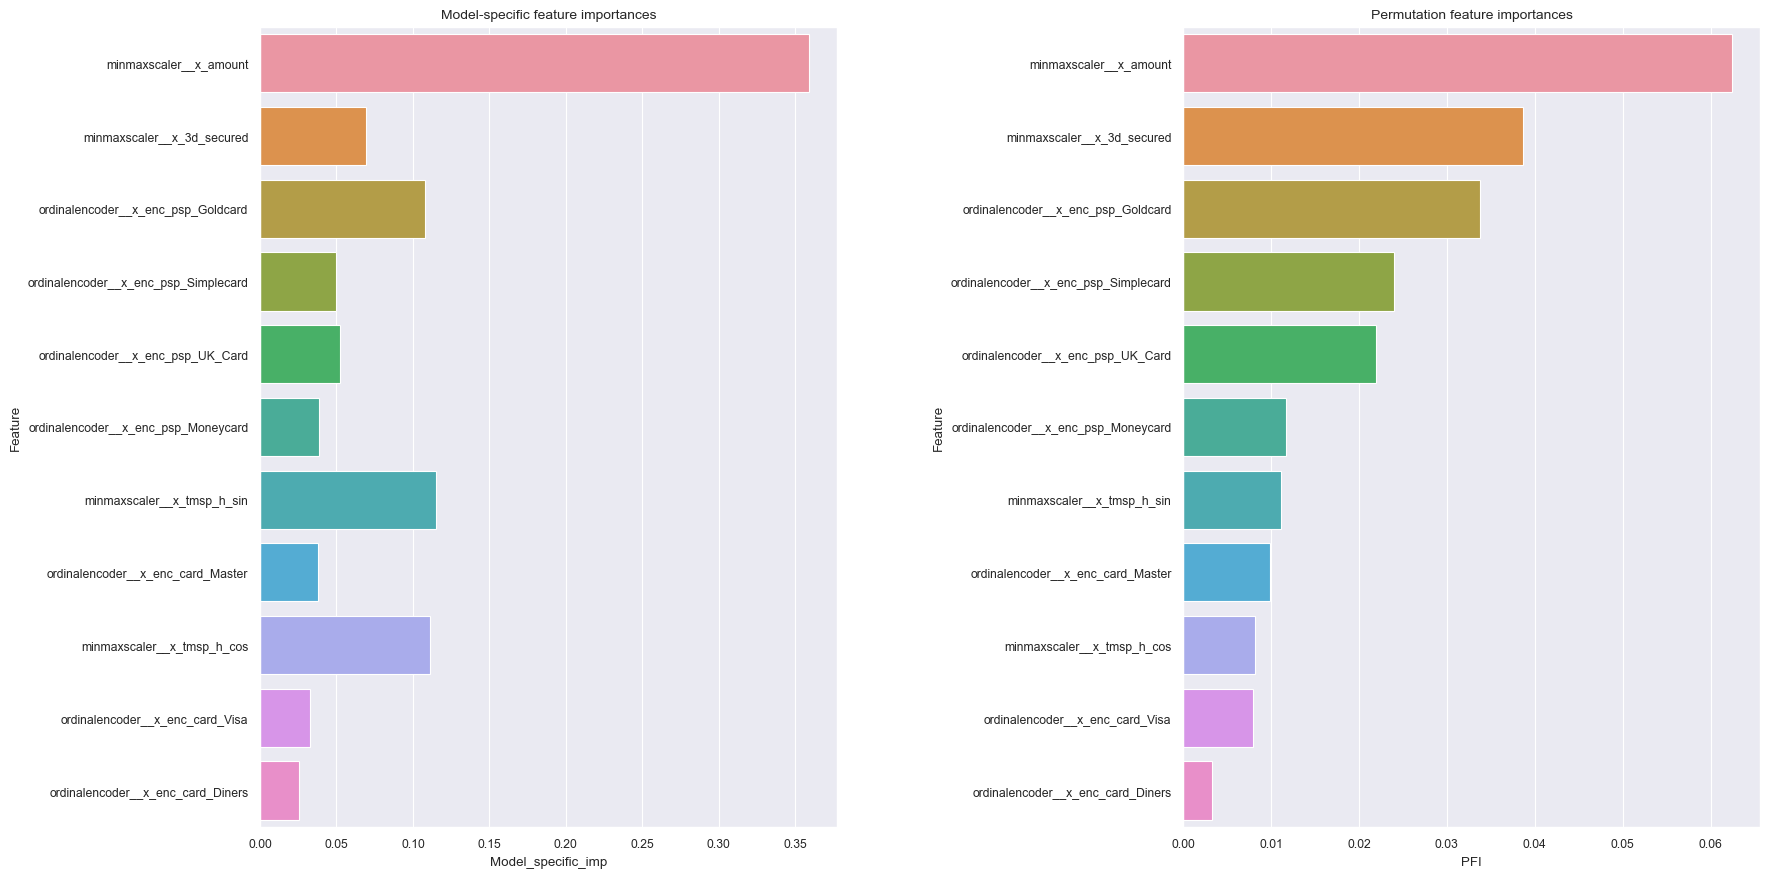

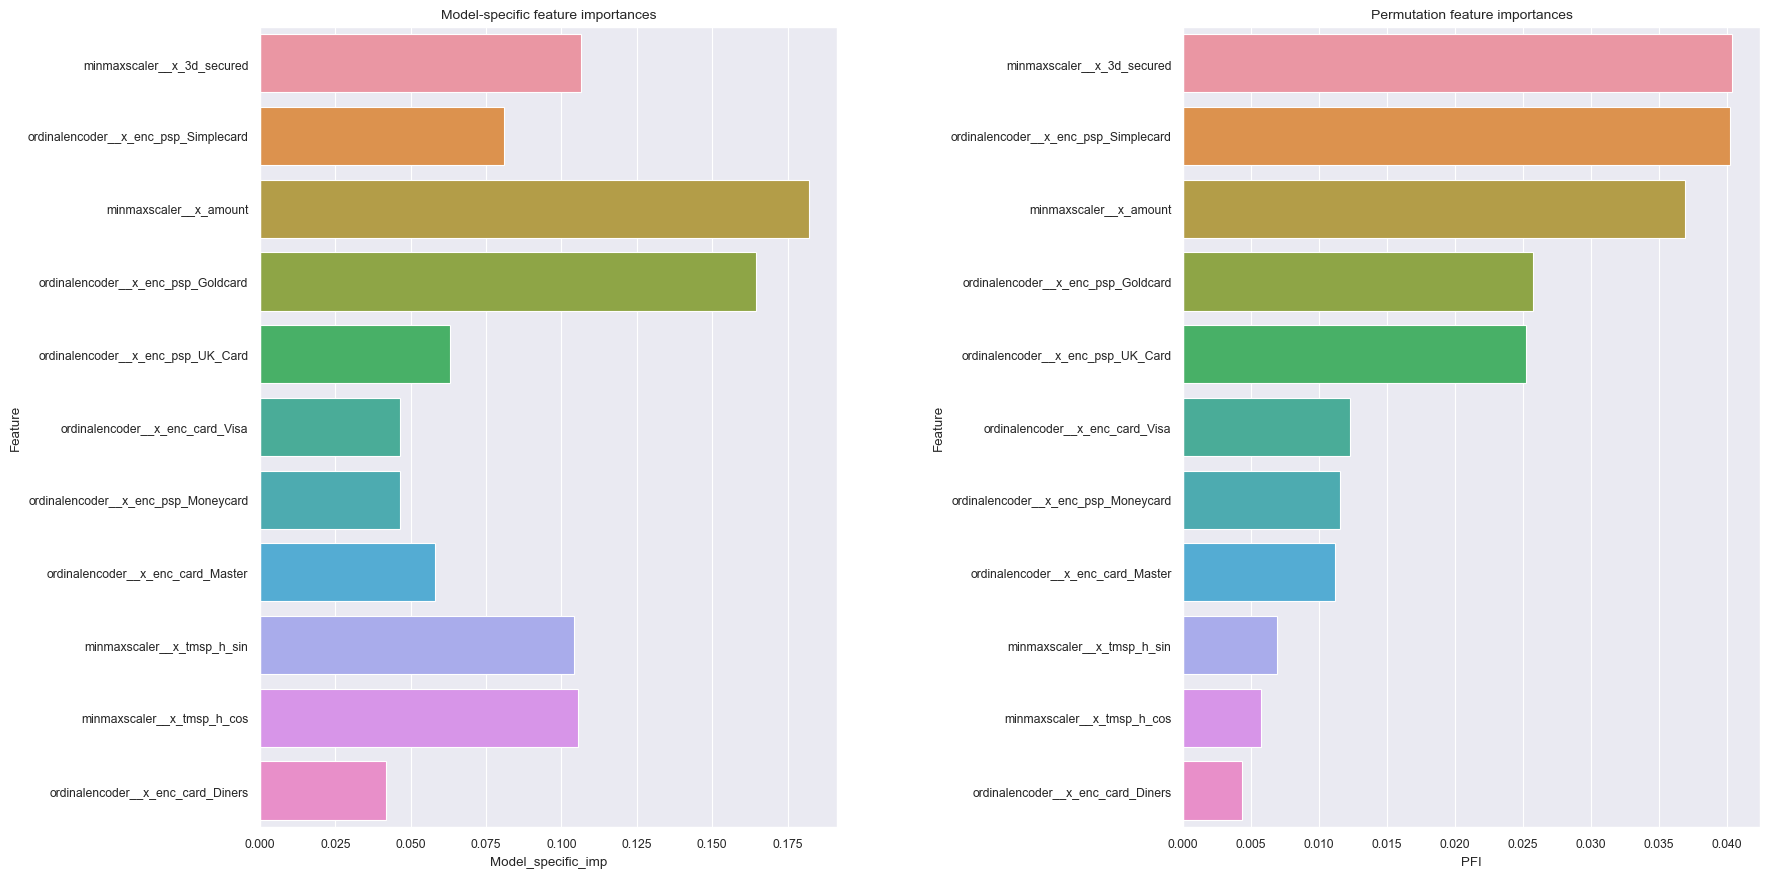

In [155]:
fourth_exp = "PSP_4b_finetune_w/_class_weights"
fourth_info = "4. Training of models WITH hyperparameter tuning & w/ REDUCED features set "
hp_tune_model(search_mode="grid", 
              zip_iter=fourth_zip, 
              x_train_raw=x_train_raw_light, x_train_numerical=x_train_numerical_light, 
              x_test_raw=x_test_raw_light, x_test_numerical=x_test_numerical_light, 
              y_train=y_train, y_test=y_test, 
              features_numerical=features_light, 
              exp_name=fourth_exp, info_text=fourth_info)

> Random Forest with best performance

In [ ]:
logged_model = logged_model = 'runs:/56c67ee16bec42f0a1bf72135dad4df9/model_saved'

# Load model as a PyFuncModel.
best_model = mlflow.pyfunc.load_model(logged_model)

## Modeling: Decision Function

# Evaluation
- Filtern nach den 1. Versuchen
- Prognose für die PSP
- Vergleich mit tatsächlich gewähltem PSP

Für die Simulation werden erst alle Transaktionen geladen. Auch die Mehrfach-Versuche für einen Kundenvorgang beim gleichen PSP.

## Evaluation dataset
Für die Simulation werden erst alle Transaktionen geladen. Auch die Mehrfach-Versuche für einen Kundenvorgang beim gleichen PSP.

In [ ]:
df_t_all = (pd.read_excel("../data/03_interim/df_trx_all.xlsx", sheet_name="df_t_all")
            .drop(columns=["Unnamed: 0"])
            .rename(columns={"x_tmsp":"meta_tmsp"}))

# customer transactions for testing only!
df_test = df_t_all[df_t_all["meta_customer_trx_id"].isin(trx_id_test)]

# remove encoded psp and not required features
remove_for_sim = [x for x in df_test.columns if (x.find("enc_psp")!=-1) or (x.find("_country")!=-1) or (x.find("_wd_")!=-1)]
df_test = df_test.drop(columns=remove_for_sim)

df_test.info()

In [ ]:
len(df_test["meta_customer_trx_id"].unique())

Vorgehensweise:
- Filtern aller Datensätzen nach den Testtransaktionen, die beim Train-Test-Split zufällig gewählt wurden.
- Gruppieren der Datensätze nach dem Kundenvorgang
- Je Kundenvorgang werden dabei die Grunddaten/Features des Kundenvorgangs benötigt, um das Vorhersage-Modell zu füttern.
- Zur Bewertung der Versuche je Kundenvorgang benötigt es die Anzahl der Versuche je PSP sowie der letztendlich erfolgreiche PSP

In [ ]:
# calculate attempts per psp and pivot by psp
df_test_atpt_per_psp = (df_test
                        .groupby(["meta_customer_trx_id", "x_psp"])[["meta_customer_atpt_no"]].count()
                        .reset_index()
                        .pivot(columns="x_psp", index="meta_customer_trx_id")
                        .fillna(0))

# rename columns
new_cols = ["sim_atpts_" + c[1] for c in df_test_atpt_per_psp.columns]
df_test_atpt_per_psp.columns = new_cols

#calculate total 
df_test_atpt_per_psp["sim_atpts_total"] = df_test_atpt_per_psp.sum(axis=1)
df_test_atpt_per_psp.info()

In [ ]:
# successful PSP per customer transaction
df_test_psp_success = (df_test[df_test["y_success"]==1].groupby(["meta_customer_trx_id"])["x_psp"].first()
                       .reset_index().rename(columns={"x_psp":"sim_psp_success"})
                       .sort_values(by="sim_psp_success", ascending=False))
df_test_psp_success.info()

In [ ]:
df_test_psp_success.head()

In [ ]:
df_test[df_test["meta_customer_trx_id"]==6713]

In [ ]:
# names of transformed features
transformed_features

In [ ]:
features_light